# Классификация возраста, пола и расы по лицу человека

Используйте публичные данные UTKfaces. https://susanqq.github.io/UTKFace/
В работе необходимо использовать данные Aligned&Cropped Faces, где произведены вырезы лиц с исходных изображений.

Изображения хранятся в формате jpg. В имени (почти!!!) каждого иображения имеется информации о человеке

$$[возраст]\_[пол]\_[раса]\_[время].jpg$$

Потребуются первые три параметра из названия каждого файлы.

В текущем файле реализована тренировка сверточной нейронной сети resnet50 для классификации возраста по фотографии. Текущая СНС используется с предобученными весами (transfer learning - перенос обучения) на датасете imagenet. Перенос обучения позволяет использовать веса сети с другого набора данных. Как правило, такой подход позволяет существенно поднять точность предсказания на новом наборе данных.

Задачи:
1. Переписать класс Dataset так, чтобы __getitem__ выдывал классы возраст, пол и раса. Задача регрессии для предсказания возраста является сложно, в этой связи будем решать ее как классификационную. Необходимо закодировать возраст в один из классов [(0, 5), (5, 14), (14, 30), (30, 45), (45, 60), (60, 120)], таким образом __getitem__ будет выдавать номер класса, которому принадлежит человек на фотографии.
Дополнительная задача (по желанию): при классификации ответом является возрастная, а не число. Можно получать возраст в числом выражении если использовать математическое ожидание по ответам нейронной сети. Для этого необходимо умножить ответы в виде Softmax на средние значения возраста в каждой группе и проссумировать все значения. 

2. Переписать класс Net. Добавить Mobilentv2 и Resnet34, так чтобы аргументом net можно было выбрать на основе какого экстрактора признаков построить сеть для классификации. Добавить дополнительные классификаторы для возраста и расы.

3. Обучить сеть. Попробуйте оптимизатор SGD и Adam. Визуализировать результаты на валидационном наборе данных.

Примечание: для тренировки лучше использовать GPU или colab.research.google.com с поддержкой GPU.

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
import torch
from torch.utils.data import Dataset
import json
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Ниже реализован класс Dataset, который имеет три обязательных метода __init__, __len__, __getitem__.

- __init__ происходит инициализация переменных датасета.
- __len__ возращает количество изображений в датасете.
- __getitem__ возвращает изображение в формате PIL и значения классов age, gender, race по индексу.

Размер изображения установить $224 \times 224$. В случае медленного обучения на процессоре параметр можно уменьшить, но потребуется произвести изменения в месте крепления экстрактора признаков и классификатора нейронной сети.

In [ ]:
T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset_(Dataset):
    'Characterizes a dataset for PyTorch'
    
    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        self.data=torch.Tensor()
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        
        names = [os.path.join(path, it) for it in names]
        np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]

        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]
                       
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)

    def __getitem__(self, index):
        'Generates one sample of data'

        ID = self.ids[index]
        
        image = Image.open(ID)

        labels=ID.split('\\')[-1].split('_')

        age = self.mark(int(labels[0]))
        gender = int(labels[1])
        race = int(labels[2])
        
        if self.transform:
            image = self.transform(image)
#             N = transforms.Compose([
#                 transforms.Normalize(self.mean, self.std)
#             ])
#             image=N(image)
        
        return image, age, gender, race
    
    def mark(self, x):
        for i in range(len(self.age_list)):
            if x in range(*self.age_list[i]):
                return i
    
    def compute_mean_and_stf(self):
        for i in tqdm(self.ids):
            image = Image.open(i)
            image = self.transform(image)
            self.data = torch.cat((self.data, image.unsqueeze(0)))
        
        self.mean = np.mean(self.data.numpy(), axis=(0, 2, 3))
        self.std = np.std(self.data.numpy(), axis=(0, 2, 3))

In [ ]:
train_data = Dataset_('UTKFace', subset='train', test_part = 0.7, transform = T)
valid_data = Dataset_('UTKFace', subset='valid', test_part = 0.7, transform = T)

In [ ]:
# train_data.compute_mean_and_stf()
# valid_data.compute_mean_and_stf()

Ниже представлен пример получения изображения по индексу.

In [ ]:
indx=random.randint(0, train_data.__len__())
img, *labels = train_data[indx]
print(indx, labels)
plt.imshow(img.numpy().transpose(1,2,0))

Объекты train_data и valid_data передадим в DataLoader. Объект train_loader и valid_loader будут выдавать пачку изображения с правильными ответами (батчи).

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=16, 
                                          shuffle=False)

In [ ]:
images, *labels = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print(labels)

In [ ]:
class Net(nn.Module):
    def __init__(self, net='mobilenetv2', pretrained=True):
        super(Net, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            self.model = mobilenet_v2(pretrained=pretrained)
            self.model.age_cls = nn.Linear(model.last_channel, 6)
            self.model.gender_cls = nn.Linear(model.last_channel, 2)
            self.model.race_cls = nn.Linear(model.last_channel, 5)
            
        elif self.net == 'resnet34':
            self.model = resnet34(pretrained=pretrained)
            self.model.age_cls = nn.Linear(self.model.fc.in_features, 6)
            self.model.gender_cls = nn.Linear(self.model.fc.in_features, 2)
            self.model.race_cls = nn.Linear(self.model.fc.in_features, 5)
            
        elif self.net == 'resnet50':
            self.model = resnet50(pretrained=pretrained)
            self.model.age_cls = nn.Linear(self.model.fc.in_features, 6)
            self.model.gender_cls = nn.Linear(self.model.fc.in_features, 2)
            self.model.race_cls = nn.Linear(self.model.fc.in_features, 5)

    def forward(self, x):
        if self.net == 'resnet50':
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            age = self.model.age_cls(x)
            gender = self.model.gender_cls(x)
            race = self.model.race_cls(x)
            
        if self.net == 'resnet34':
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            age = self.model.age_cls(x)
            gender = self.model.gender_cls(x)
            race = self.model.race_cls(x)
        
        if self.net == 'mobilenetv2':
            x = self.model.features(x)
            x = x.mean([2, 3])
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)
            
        return age, gender, race

In [ ]:
results={'resnet50':{'sgd':{},'adam':{}},
         'resnet34':{'sgd':{},'adam':{}},
         'mobilenetv2':{'sgd':{},'adam':{}}}

In [ ]:
for net in results:
    for optmzr in results[net]:

        results[net][optmzr]['loss']=[]
        results[net][optmzr]['val_loss']=[]
        results[net][optmzr]['acc_age']=[]
        results[net][optmzr]['val_acc_age']=[]
        results[net][optmzr]['acc_gender']=[]
        results[net][optmzr]['val_acc_gender']=[]
        results[net][optmzr]['acc_race']=[]
        results[net][optmzr]['val_acc_race']=[]
        
        model = Net(net=net).cuda()

        criterion = nn.CrossEntropyLoss().cuda()
        
        optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9) if optmzr == 'sgd' else optim.Adam(model.parameters(), lr=1e-3)
        
        print(f'BEGIN {net} {optmzr}')
        
        for epoch in range(1):

            for phase in ['train', 'valid']:
                print(phase)
                if phase == 'train':

                    model.train()

                    running_loss = 0.
                    correct = 0
                    total = 0

                    age_correct = 0
                    gender_correct = 0
                    race_correct = 0

                    for i, data in enumerate(train_loader):
                        # get the inputs; data is a list of [inputs, labels]
                        inputs, targets = data[0].to(device), (data[1].to(device), data[2].to(device), data[3].to(device))

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward + backward + optimize
                        out = model(inputs)

                        loss_age = criterion(out[0], targets[0])
                        loss_gender = criterion(out[1], targets[1])
                        loss_race = criterion(out[2], targets[2])

                        loss = loss_age + loss_gender + loss_race

                        loss.backward()
                        optimizer.step()

                        # print statistics
                        running_loss += loss.item()

                        _, age_pred = torch.max(out[0].data, 1)
                        _, gender_pred = torch.max(out[1].data, 1)
                        _, race_pred = torch.max(out[2].data, 1)

                        total += targets[0].size(0)

                        age_correct += (age_pred == targets[0]).sum().item()
                        gender_correct += (gender_pred == targets[1]).sum().item()
                        race_correct += (race_pred == targets[2]).sum().item()
                        
                elif phase == 'valid':

                    with torch.no_grad():
                        model.eval()

                        validation_loss = 0.
                        v_correct = 0
                        v_total = 0

                        v_age_correct = 0
                        v_gender_correct = 0
                        v_race_correct = 0

                        for j, v_data in enumerate(valid_loader):
                            v_inputs, v_outputs = v_data[0].to(device), (v_data[1].to(device), v_data[2].to(device), v_data[3].to(device))

                            v_out = model(v_inputs)

                            v_loss_age = criterion(v_out[0], v_outputs[0]).item()
                            v_loss_gender = criterion(v_out[1], v_outputs[1]).item()
                            v_loss_race = criterion(v_out[2], v_outputs[2]).item()

                            validation_loss += v_loss_age + v_loss_gender + v_loss_race

                            _, v_age_pred = torch.max(v_out[0].data, 1)
                            _, v_gender_pred = torch.max(v_out[1].data, 1)
                            _, v_race_pred = torch.max(v_out[2].data, 1)

                            v_total += v_outputs[0].size(0)

                            v_age_correct += (v_age_pred == v_outputs[0]).sum().item()
                            v_gender_correct += (v_gender_pred == v_outputs[1]).sum().item()
                            v_race_correct += (v_race_pred == v_outputs[2]).sum().item()

                        
            print(f"""Epoch {epoch + 1} loss: {running_loss / len(train_loader):.3f} val_loss: {validation_loss / len(valid_loader):.3f} acc_age: {age_correct / total:.3f} val_acc_age: {v_age_correct / v_total:.3f} acc_gender: {gender_correct / total:.3f} val_acc_gender: {v_gender_correct / v_total:.3f} acc_race: {race_correct / total:.3f} val_acc_race: {v_race_correct / v_total:.3f}""" )
            
            
            results[net][optmzr]['loss'].append(running_loss / len(train_loader))
            results[net][optmzr]['val_loss'].append(validation_loss / len(valid_loader))
            results[net][optmzr]['acc_age'].append(age_correct / total)
            results[net][optmzr]['val_acc_age'].append(v_age_correct / v_total)
            results[net][optmzr]['acc_gender'].append(gender_correct / total)
            results[net][optmzr]['val_acc_gender'].append(v_gender_correct / v_total)
            results[net][optmzr]['acc_race'].append(race_correct / total)
            results[net][optmzr]['val_acc_race'].append(v_race_correct / v_total)

        print(f'END {net} {optmzr}')

json.dump(results, open('utkface_res.josn', 'w'))

In [3]:
results=json.load(open('utkface_res.json','r'))

# 10 epochs

resnet50 sgd
		loss	val_loss	acc_age	val_acc_age	acc_gender	val_acc_gender	acc_race	val_acc_race
Epoch 0		3.676	3.499		0.352	0.362		0.639		0.744		0.418		0.439
Epoch 1		3.383	3.221		0.373	0.401		0.752		0.783		0.455		0.503
Epoch 2		3.126	2.972		0.430	0.468		0.780		0.805		0.513		0.570
Epoch 3		2.909	2.771		0.496	0.509		0.797		0.815		0.559		0.594
Epoch 4		2.737	2.616		0.525	0.538		0.812		0.834		0.595		0.627
Epoch 5		2.593	2.495		0.543	0.551		0.828		0.844		0.618		0.645
Epoch 6		2.476	2.411		0.555	0.561		0.836		0.853		0.639		0.646
Epoch 7		2.377	2.320		0.564	0.570		0.847		0.847		0.655		0.670
Epoch 8		2.305	2.256		0.576	0.569		0.853		0.863		0.668		0.686
Epoch 9		2.230	2.169		0.584	0.583		0.857		0.866		0.685		0.705


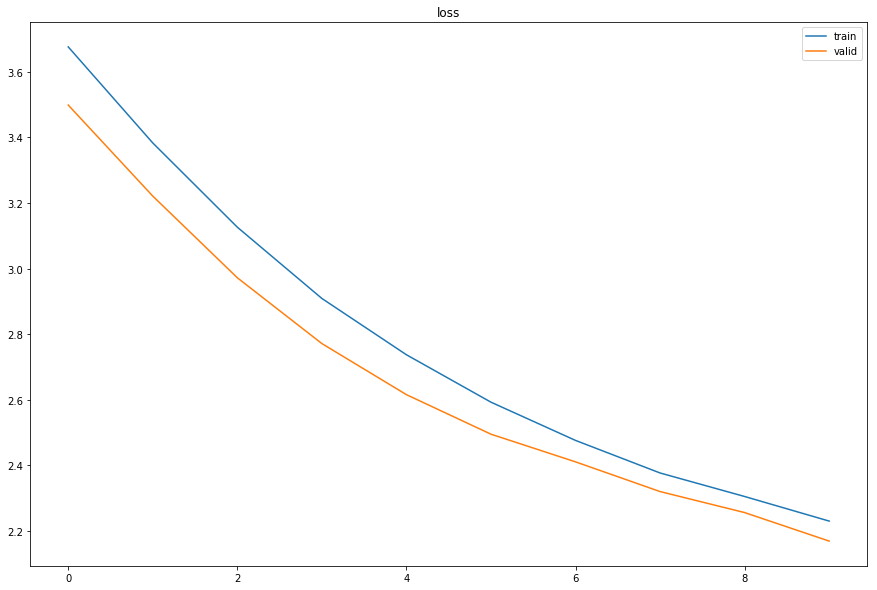

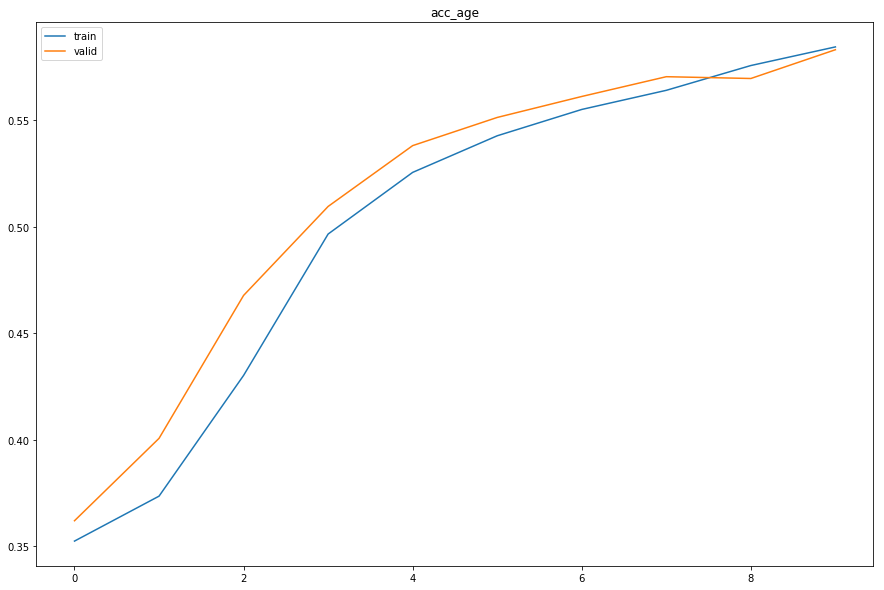

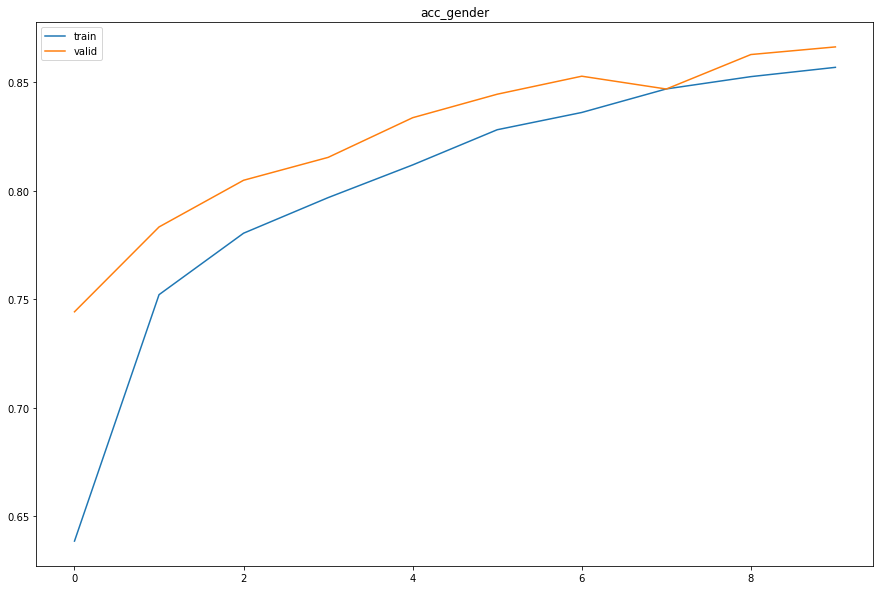

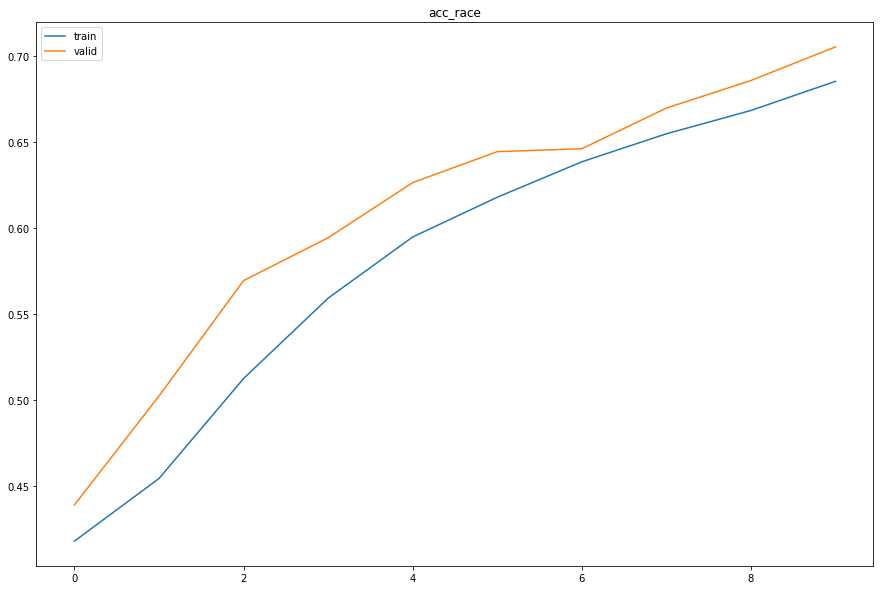

resnet50 adam
		loss	val_loss	acc_age	val_acc_age	acc_gender	val_acc_gender	acc_race	val_acc_race
Epoch 0		2.509	2.219		0.512	0.570		0.811		0.848		0.643		0.688
Epoch 1		1.961	1.922		0.590	0.606		0.867		0.853		0.744		0.757
Epoch 2		1.730	1.967		0.635	0.577		0.888		0.897		0.783		0.738
Epoch 3		1.575	1.658		0.654	0.658		0.908		0.910		0.806		0.773
Epoch 4		1.441	1.599		0.678	0.649		0.917		0.901		0.825		0.808
Epoch 5		1.323	1.698		0.697	0.648		0.930		0.895		0.839		0.800
Epoch 6		1.161	1.588		0.727	0.660		0.938		0.906		0.868		0.813
Epoch 7		0.988	1.731		0.762	0.641		0.951		0.909		0.889		0.807
Epoch 8		0.839	2.042		0.801	0.631		0.960		0.906		0.909		0.802
Epoch 9		0.691	1.998		0.838	0.664		0.967		0.882		0.926		0.800


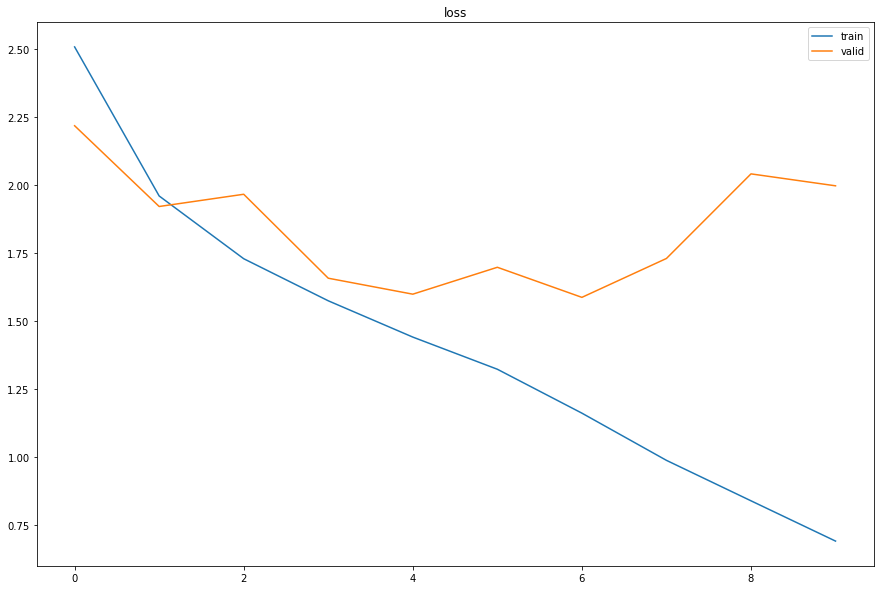

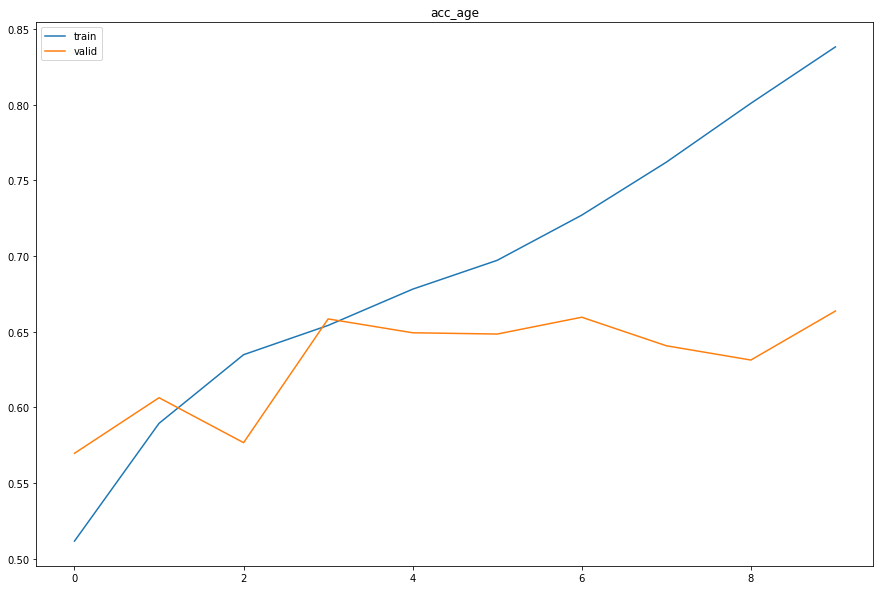

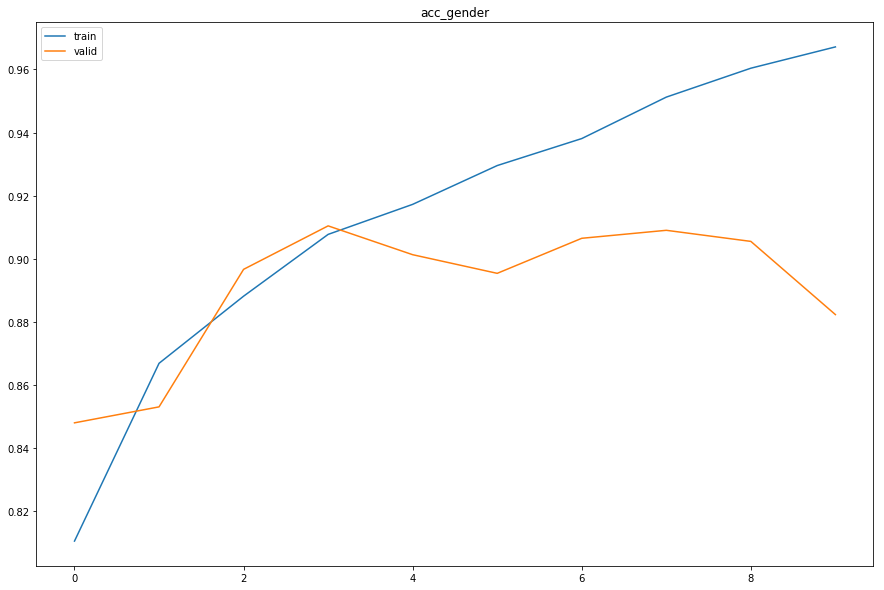

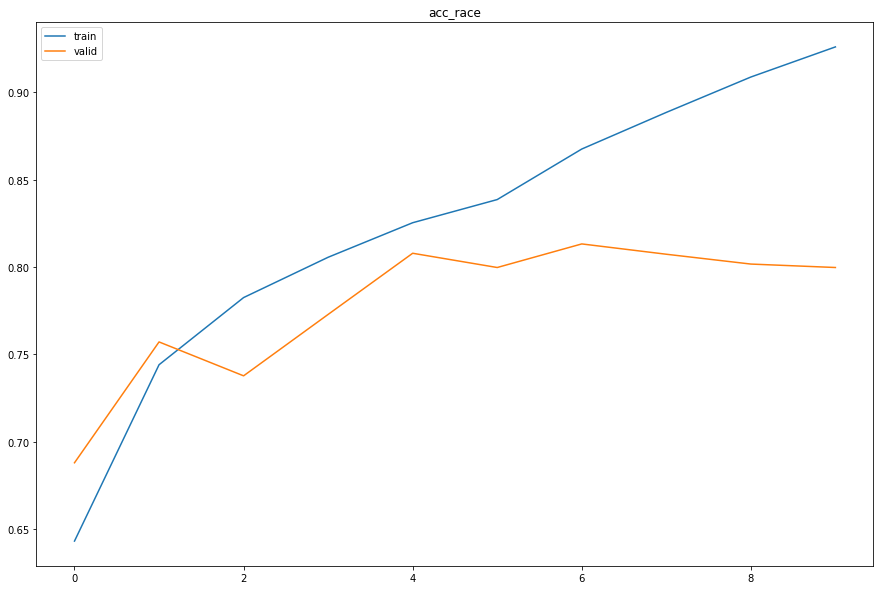

resnet34 sgd
		loss	val_loss	acc_age	val_acc_age	acc_gender	val_acc_gender	acc_race	val_acc_race
Epoch 0		3.659	3.358		0.351	0.396		0.649		0.739		0.410		0.480
Epoch 1		3.182	3.019		0.432	0.471		0.769		0.787		0.499		0.542
Epoch 2		2.903	2.812		0.494	0.512		0.795		0.812		0.550		0.564
Epoch 3		2.706	2.617		0.522	0.530		0.811		0.823		0.593		0.617
Epoch 4		2.560	2.523		0.542	0.539		0.829		0.825		0.619		0.644
Epoch 5		2.432	2.384		0.559	0.546		0.839		0.845		0.647		0.665
Epoch 6		2.334	2.288		0.570	0.564		0.845		0.855		0.666		0.685
Epoch 7		2.249	2.257		0.584	0.564		0.852		0.862		0.684		0.674
Epoch 8		2.183	2.147		0.588	0.576		0.857		0.865		0.697		0.717
Epoch 9		2.106	2.085		0.599	0.592		0.864		0.873		0.712		0.720


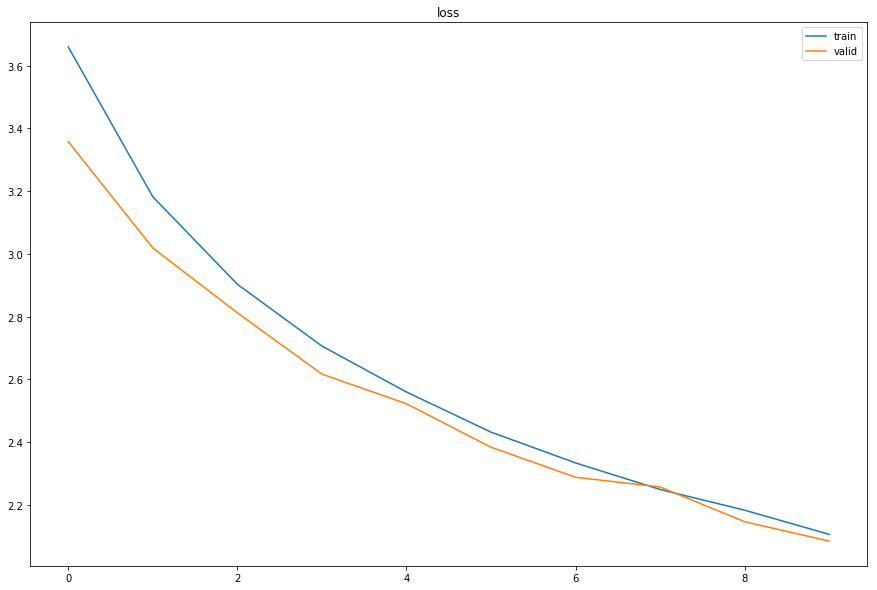

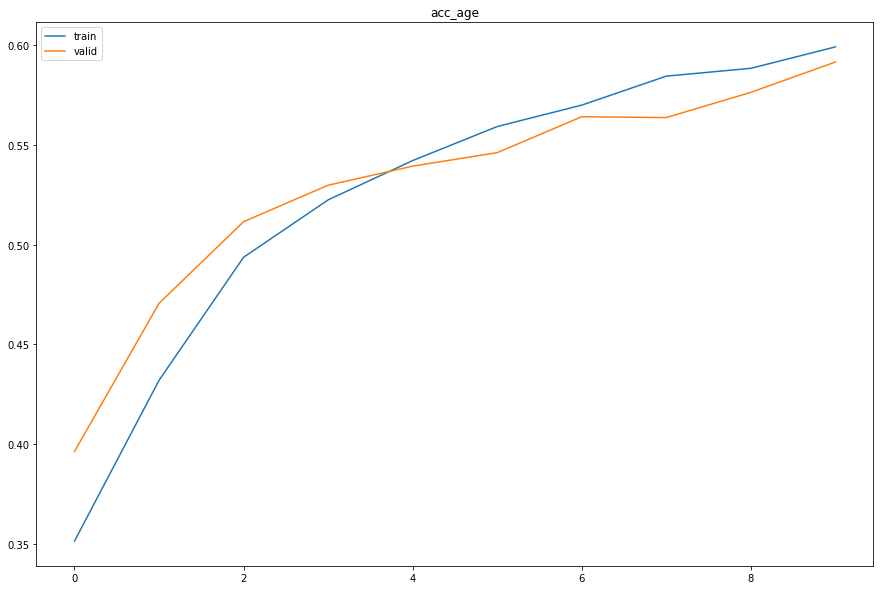

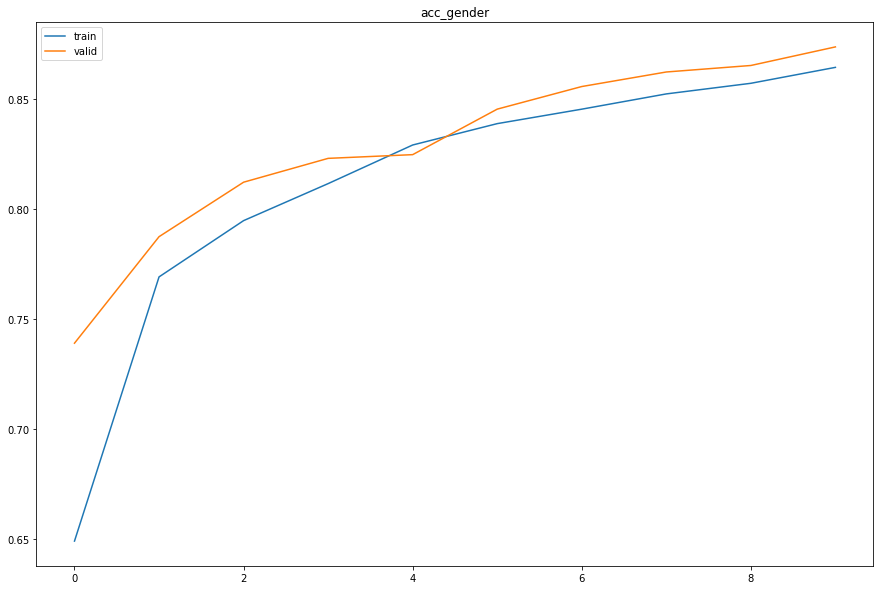

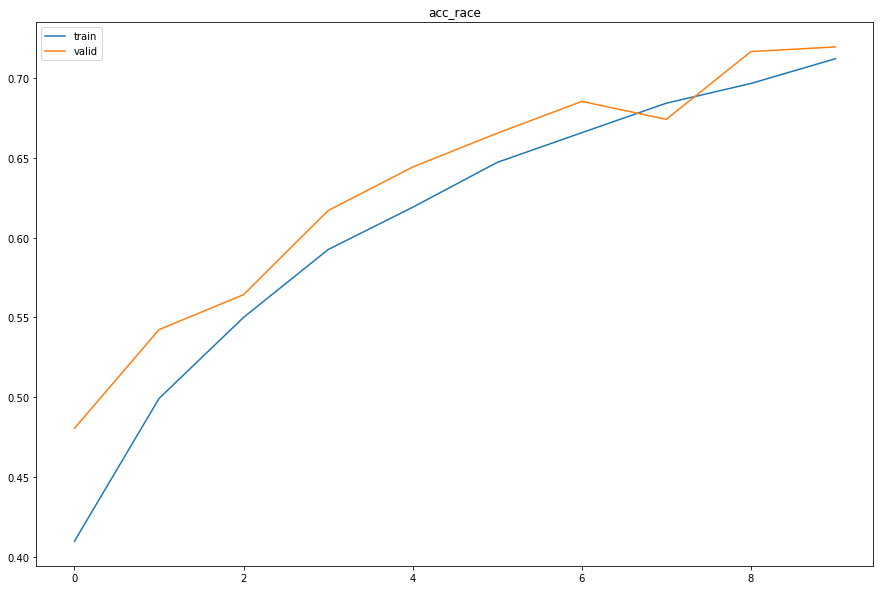

resnet34 adam
		loss	val_loss	acc_age	val_acc_age	acc_gender	val_acc_gender	acc_race	val_acc_race
Epoch 0		2.323	1.941		0.544	0.600		0.831		0.883		0.677		0.742
Epoch 1		1.800	1.817		0.619	0.576		0.885		0.892		0.771		0.796
Epoch 2		1.584	1.591		0.647	0.654		0.907		0.902		0.805		0.810
Epoch 3		1.409	2.016		0.682	0.647		0.922		0.890		0.831		0.699
Epoch 4		1.219	1.563		0.716	0.673		0.937		0.914		0.857		0.815
Epoch 5		1.040	1.703		0.747	0.661		0.948		0.914		0.887		0.798
Epoch 6		0.843	1.915		0.801	0.659		0.959		0.902		0.913		0.804
Epoch 7		0.656	1.937		0.846	0.658		0.972		0.911		0.932		0.809
Epoch 8		0.494	2.064		0.890	0.670		0.977		0.920		0.955		0.784
Epoch 9		0.384	2.393		0.913	0.630		0.985		0.912		0.964		0.812


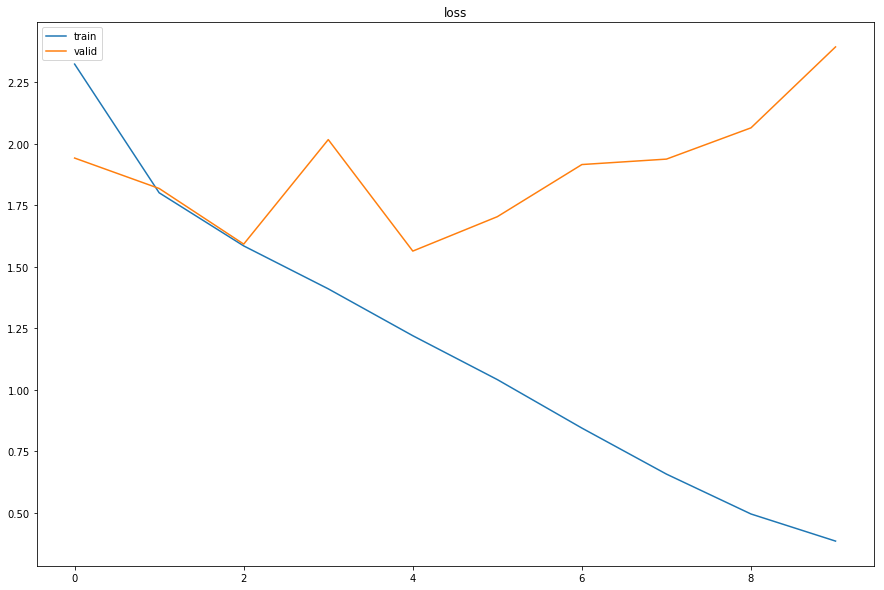

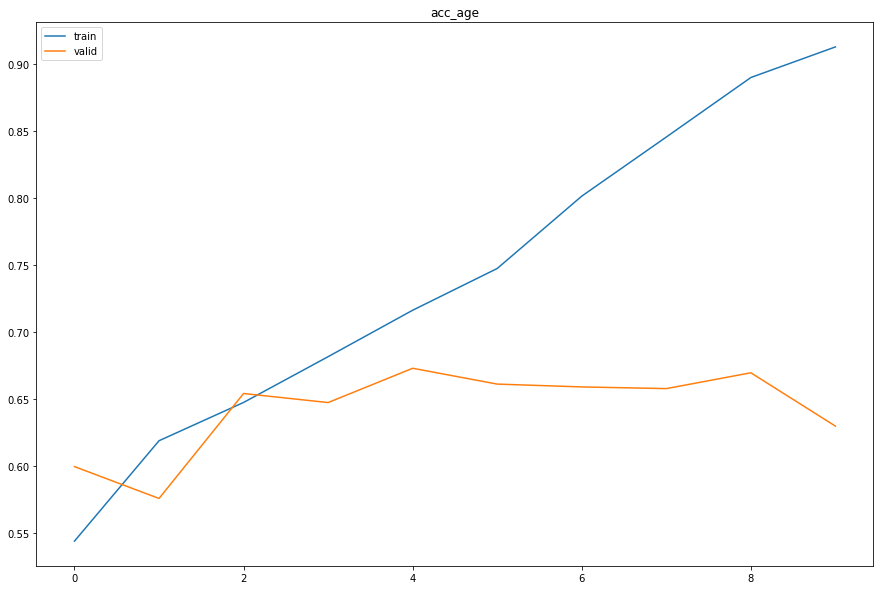

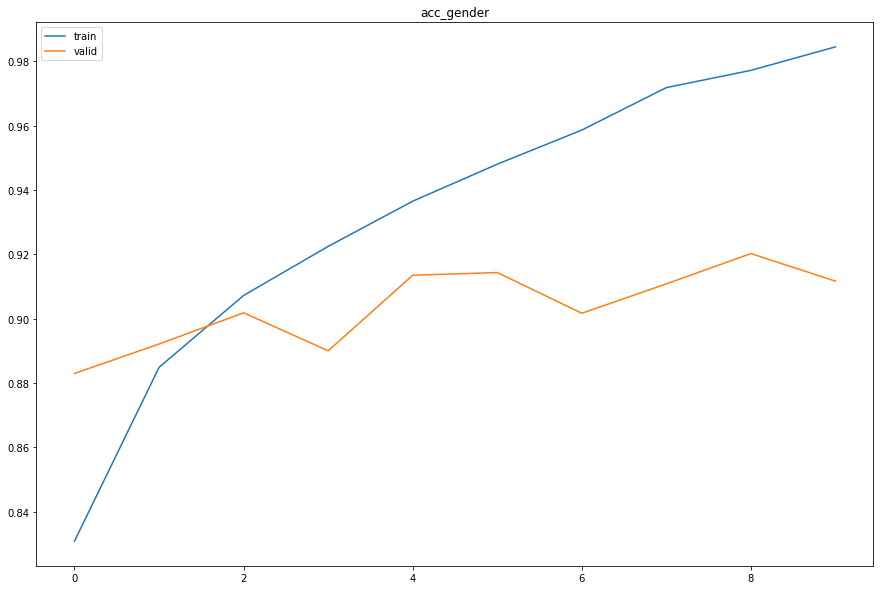

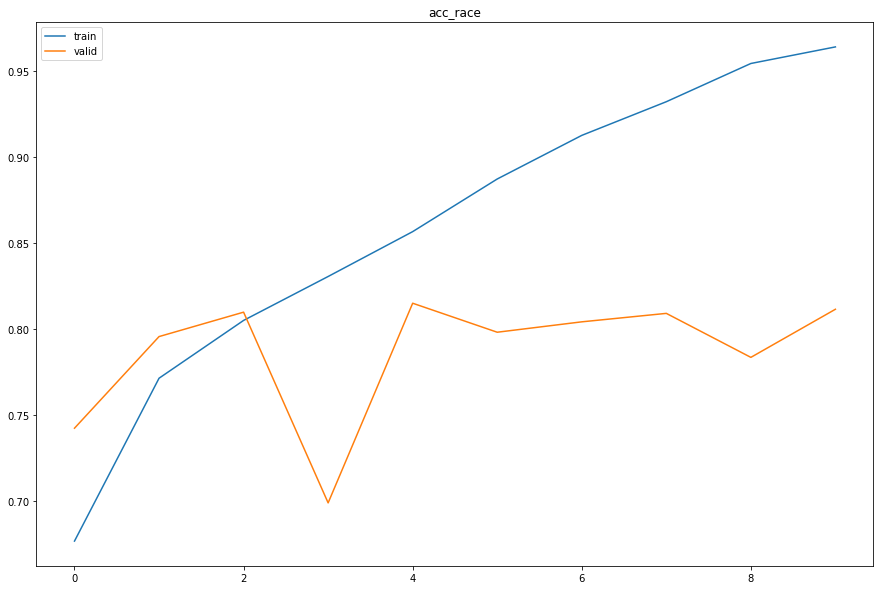

mobilenetv2 sgd
		loss	val_loss	acc_age	val_acc_age	acc_gender	val_acc_gender	acc_race	val_acc_race
Epoch 0		3.621	3.369		0.357	0.386		0.648		0.736		0.429		0.487
Epoch 1		3.230	3.041		0.429	0.458		0.748		0.771		0.493		0.552
Epoch 2		2.970	2.845		0.486	0.497		0.775		0.796		0.553		0.587
Epoch 3		2.788	2.662		0.512	0.516		0.796		0.812		0.586		0.619
Epoch 4		2.651	2.537		0.529	0.533		0.809		0.824		0.610		0.642
Epoch 5		2.533	2.441		0.544	0.549		0.822		0.835		0.630		0.654
Epoch 6		2.444	2.365		0.556	0.560		0.830		0.838		0.646		0.666
Epoch 7		2.367	2.269		0.563	0.570		0.838		0.848		0.660		0.677
Epoch 8		2.304	2.230		0.571	0.571		0.844		0.857		0.673		0.676
Epoch 9		2.242	2.161		0.580	0.578		0.849		0.856		0.681		0.697


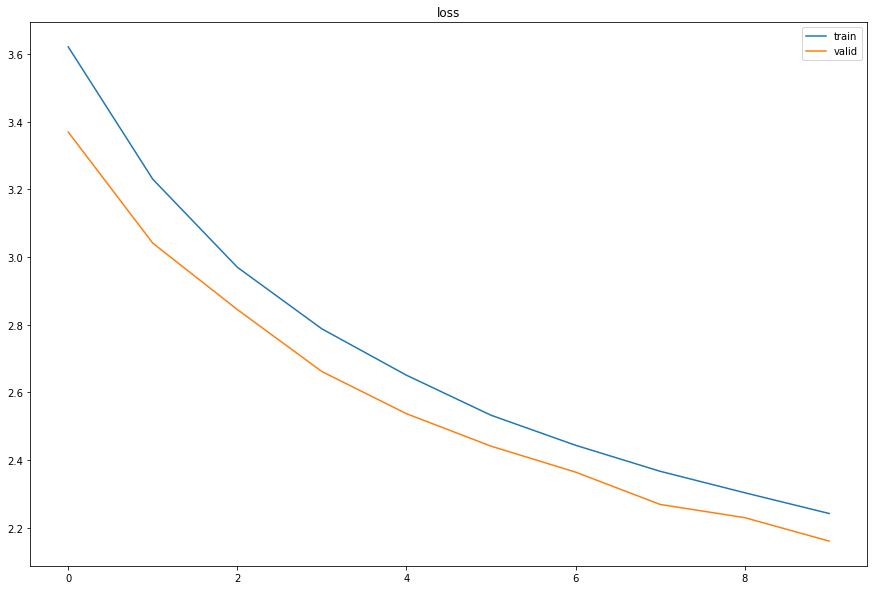

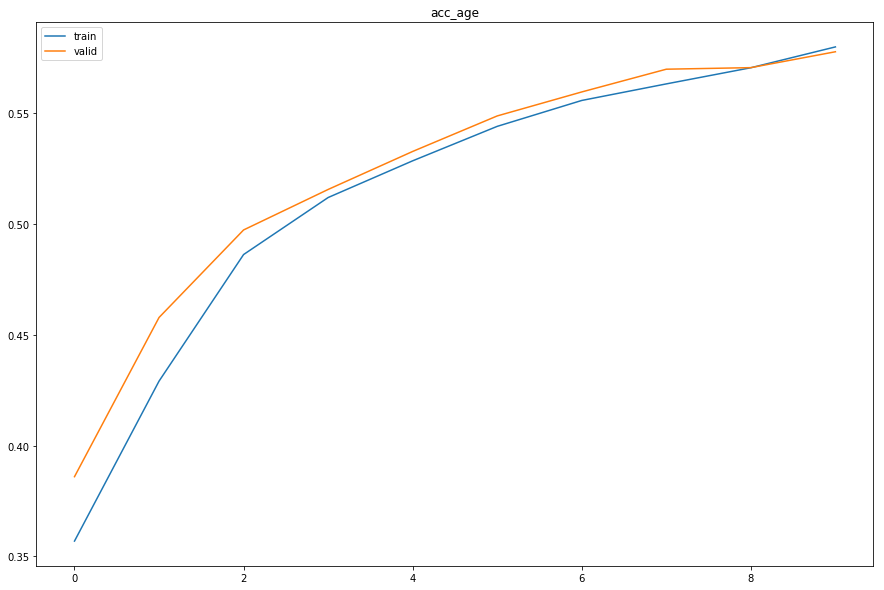

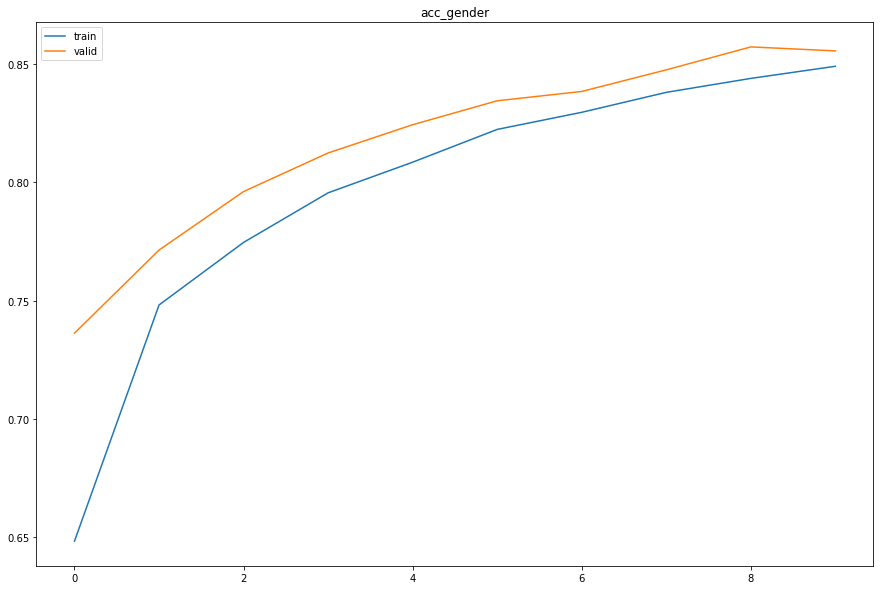

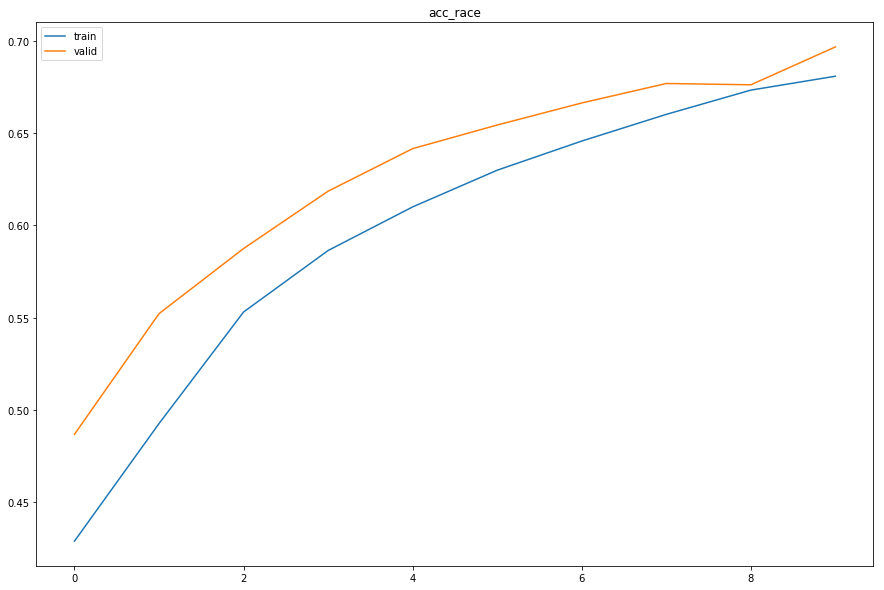

mobilenetv2 adam
		loss	val_loss	acc_age	val_acc_age	acc_gender	val_acc_gender	acc_race	val_acc_race
Epoch 0		2.267	1.857		0.552	0.609		0.837		0.871		0.686		0.767
Epoch 1		1.823	1.748		0.617	0.642		0.884		0.878		0.768		0.764
Epoch 2		1.690	1.628		0.639	0.644		0.892		0.915		0.786		0.797
Epoch 3		1.575	1.581		0.650	0.634		0.911		0.902		0.806		0.810
Epoch 4		1.499	1.585		0.663	0.655		0.910		0.910		0.818		0.808
Epoch 5		1.417	1.590		0.681	0.662		0.918		0.922		0.829		0.795
Epoch 6		1.345	1.549		0.690	0.667		0.926		0.922		0.840		0.800
Epoch 7		1.278	1.561		0.705	0.664		0.927		0.902		0.847		0.819
Epoch 8		1.232	1.949		0.724	0.588		0.935		0.909		0.862		0.805
Epoch 9		1.473	1.504		0.674	0.671		0.911		0.913		0.819		0.819


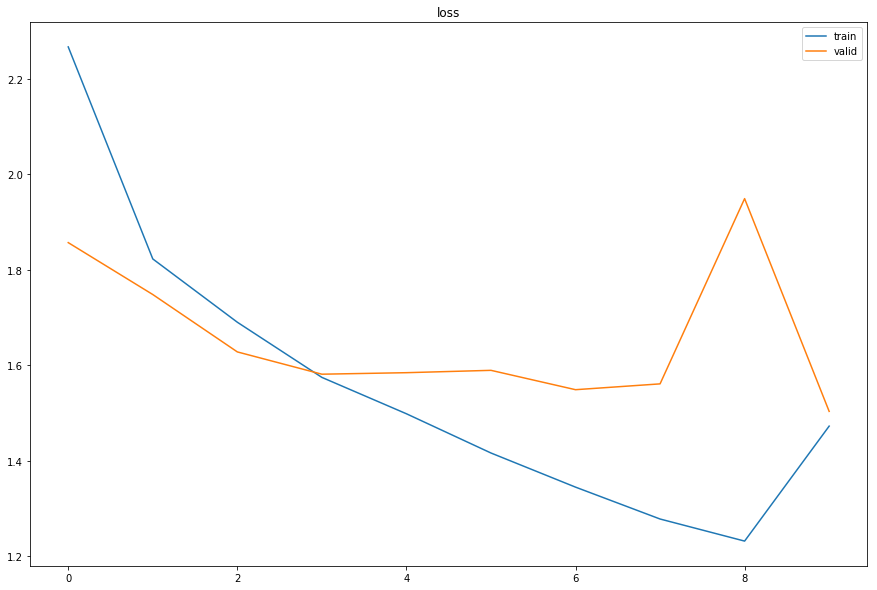

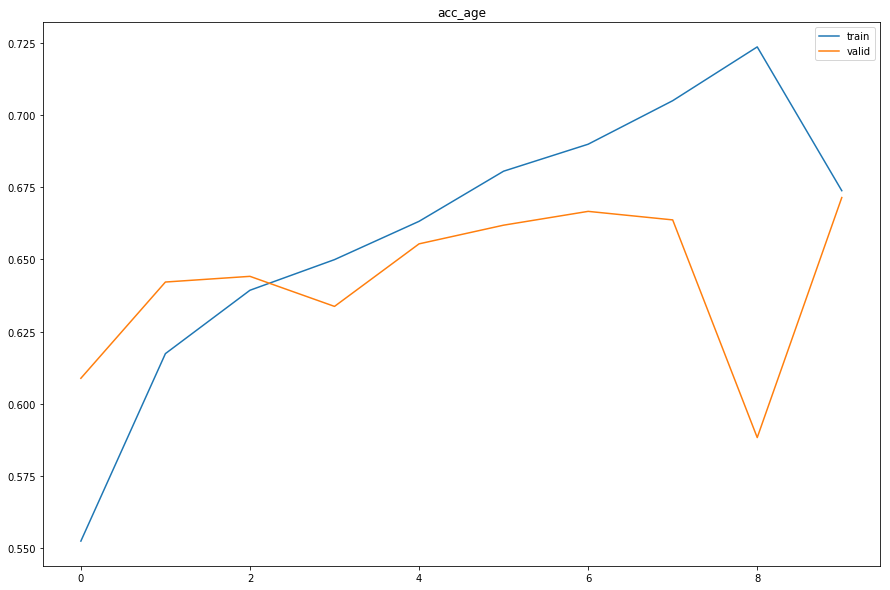

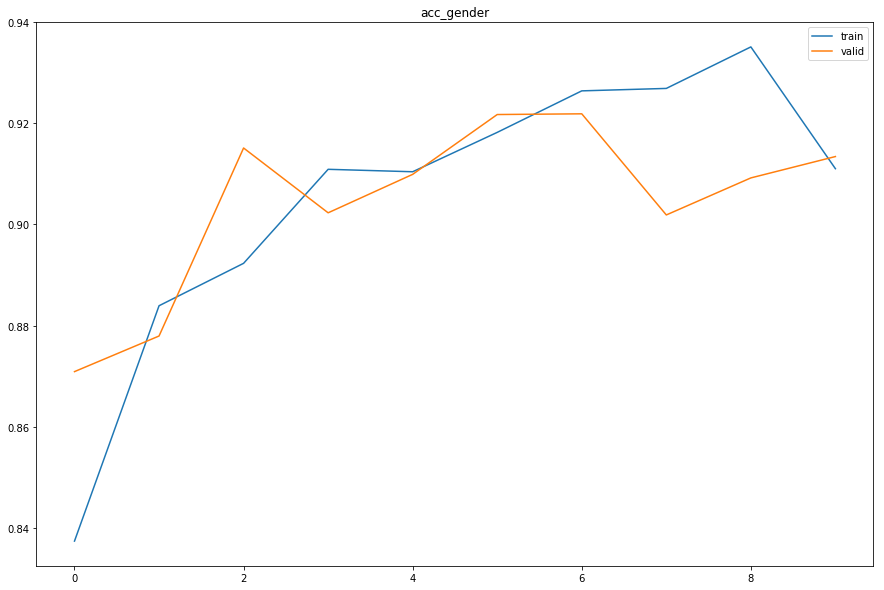

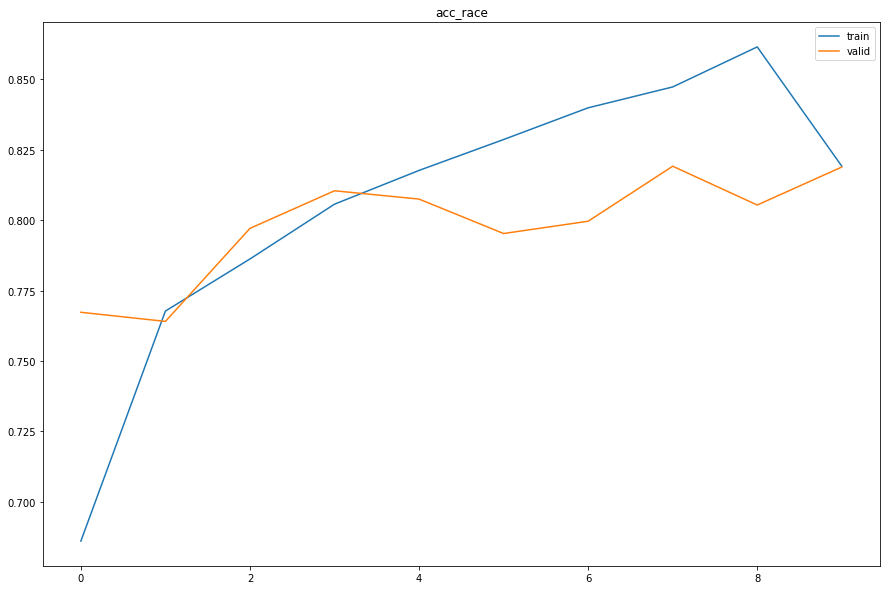

In [56]:
for n in results:
    for o in results[n]:
        print(n, o)
        print(f"""\t\tloss\tval_loss\tacc_age\tval_acc_age\tacc_gender\tval_acc_gender\tacc_race\tval_acc_race""")
        for e in range(10):
            print(f"""Epoch {str(e + 1).zfill(2)}\t{results[n][o]['loss'][e]:.3f}\t{results[n][o]['val_loss'][e]:.3f}\t\t{results[n][o]['acc_age'][e]:.3f}\t{results[n][o]['val_acc_age'][e]:.3f}\t\t{results[n][o]['acc_gender'][e]:.3f}\t\t{results[n][o]['val_acc_gender'][e]:.3f}\t\t{results[n][o]['acc_race'][e]:.3f}\t\t{results[n][o]['val_acc_race'][e]:.3f}""")
        plt.figure(figsize=(15,10))
        plt.title('loss')
        plt.plot(results[n][o]['loss'], label='train')
        plt.plot(results[n][o]['val_loss'], label='valid')
        plt.legend()
        plt.show()

        plt.figure(figsize=(15,10))
        plt.title('acc_age')
        plt.plot(results[n][o]['acc_age'], label='train')
        plt.plot(results[n][o]['val_acc_age'], label='valid')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(15,10))
        plt.title('acc_gender')
        plt.plot(results[n][o]['acc_gender'], label='train')
        plt.plot(results[n][o]['val_acc_gender'], label='valid')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(15,10))
        plt.title('acc_race')
        plt.plot(results[n][o]['acc_race'], label='train')
        plt.plot(results[n][o]['val_acc_race'], label='valid')
        plt.legend()
        plt.show()

# Optimizers comparision

resnet50


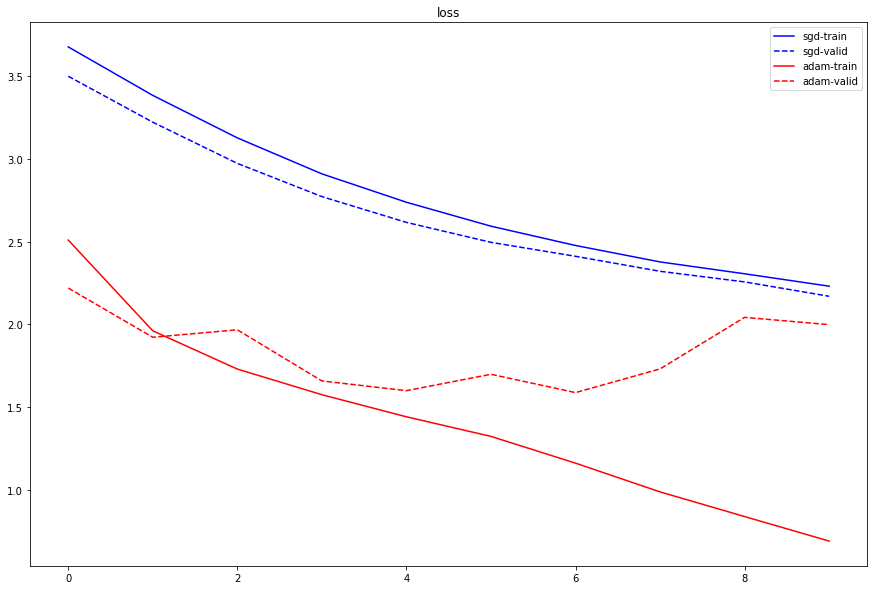

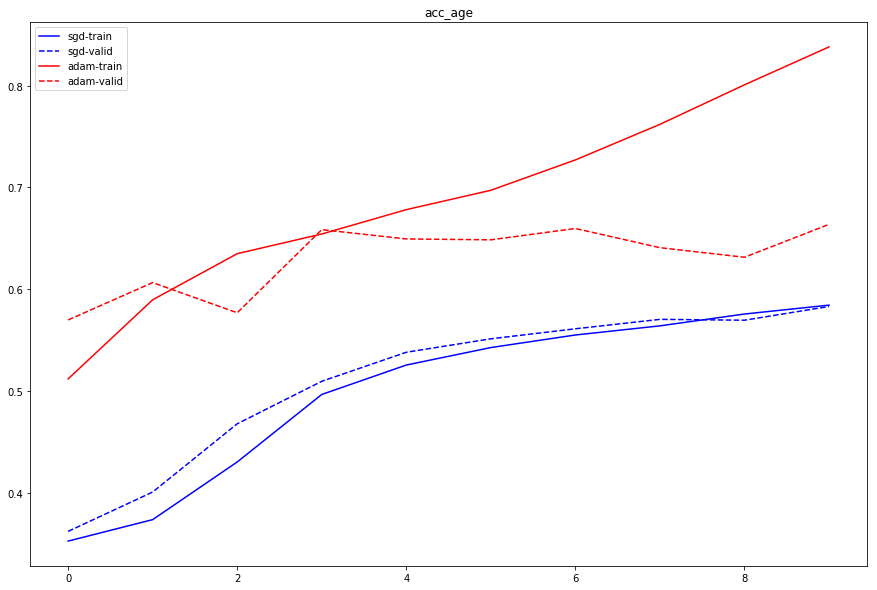

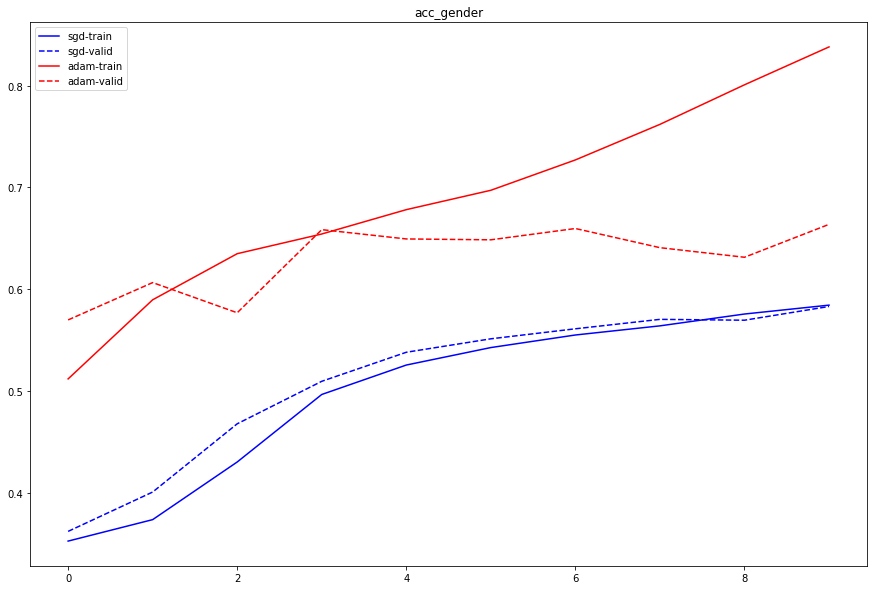

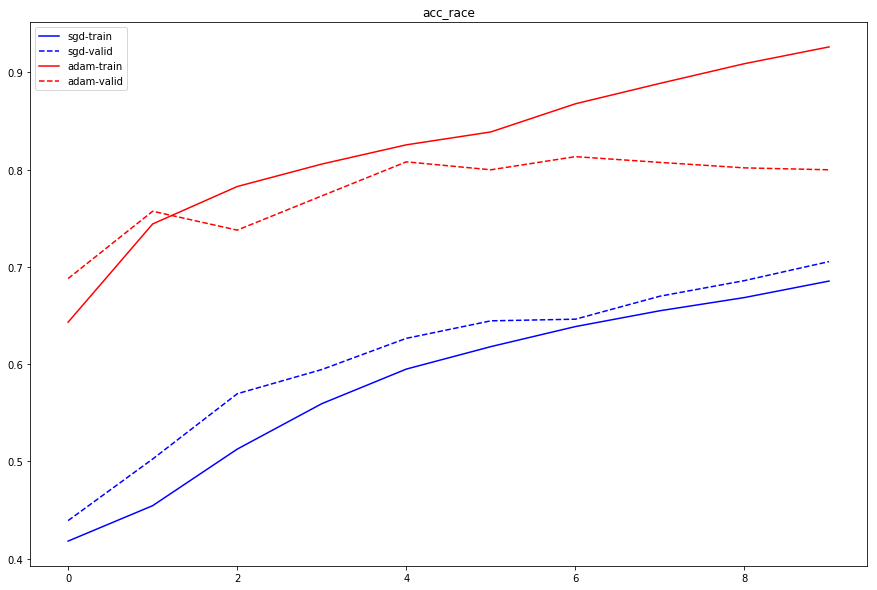

resnet34


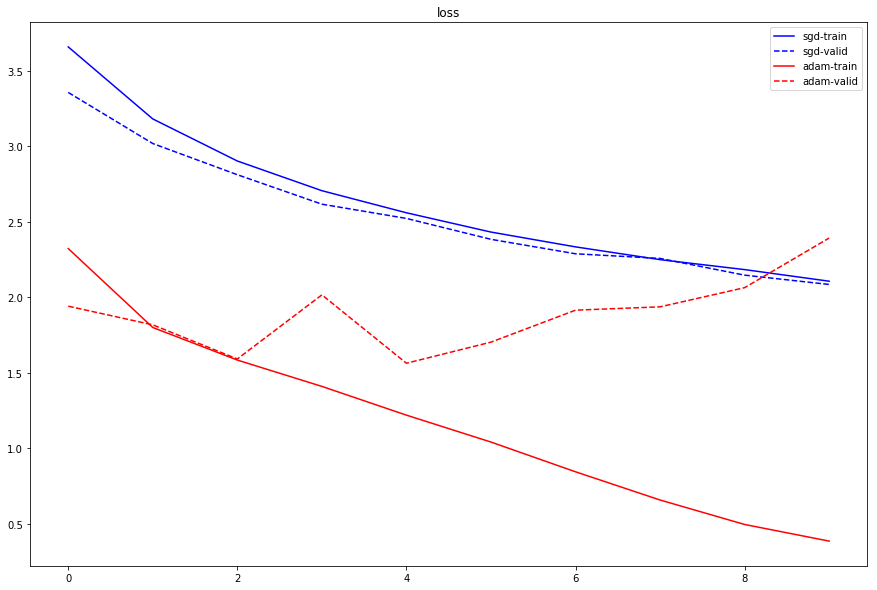

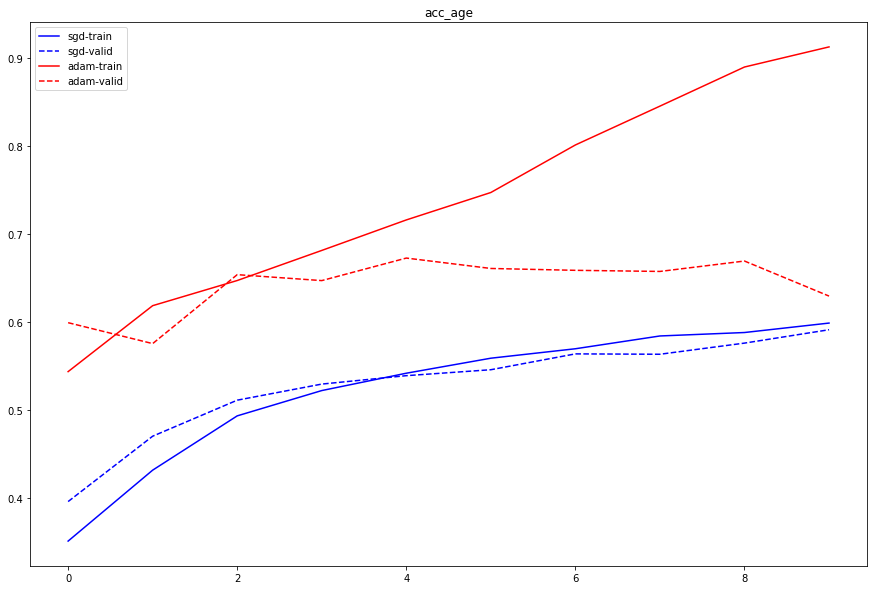

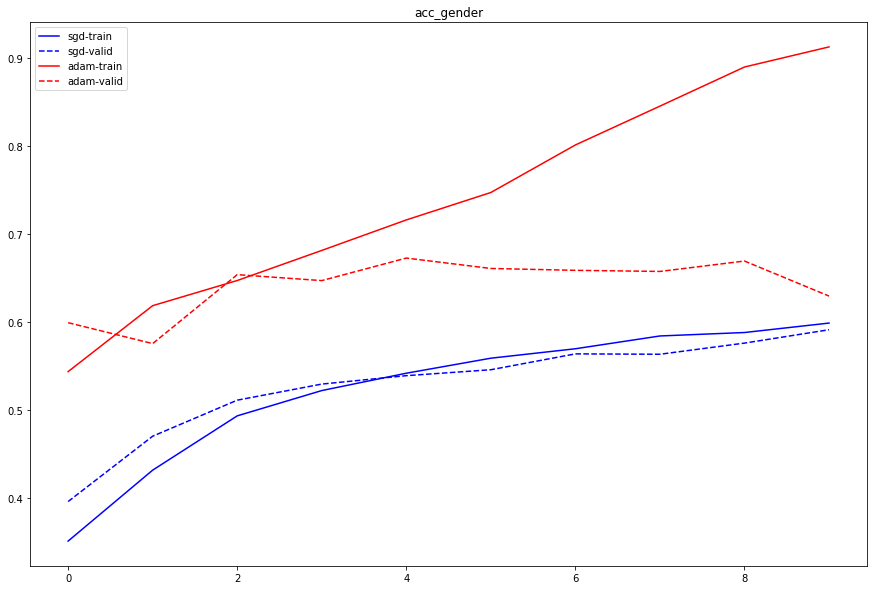

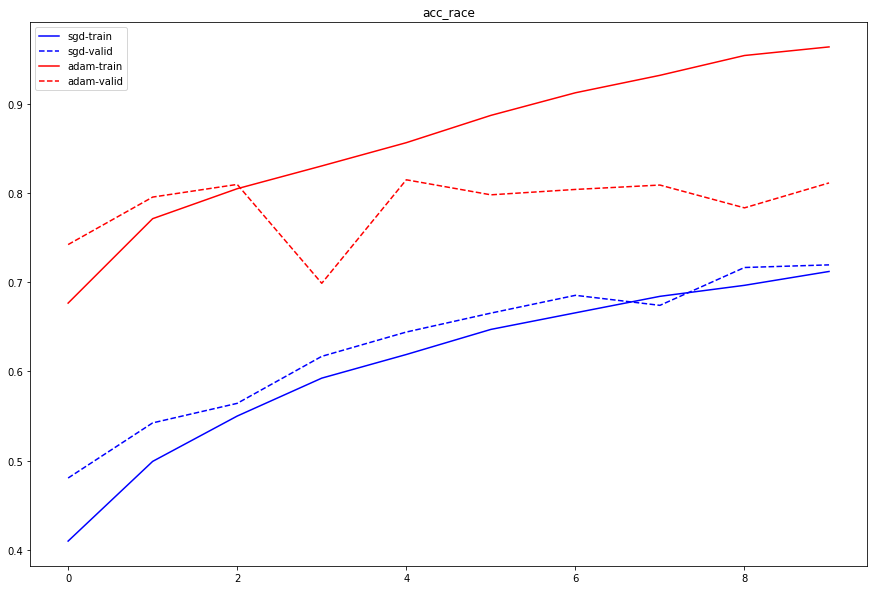

mobilenetv2


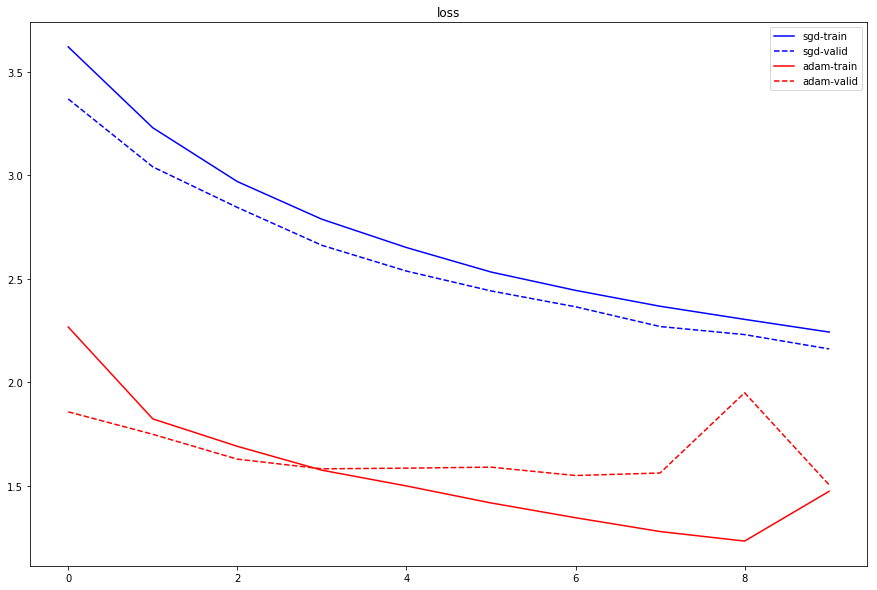

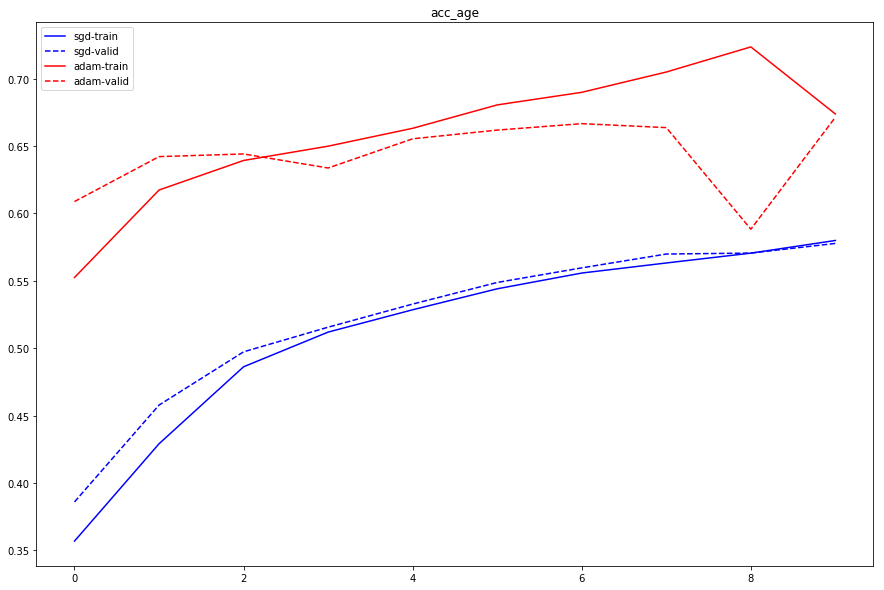

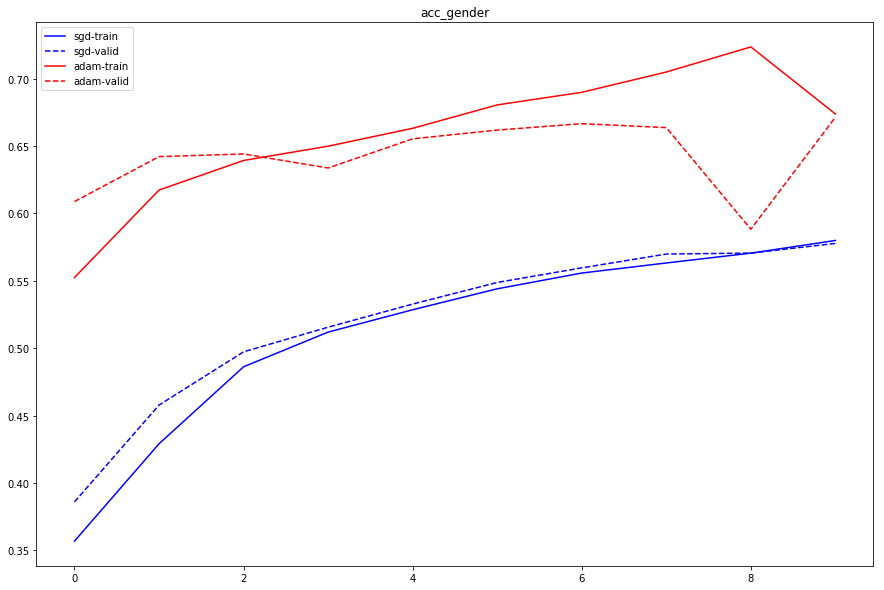

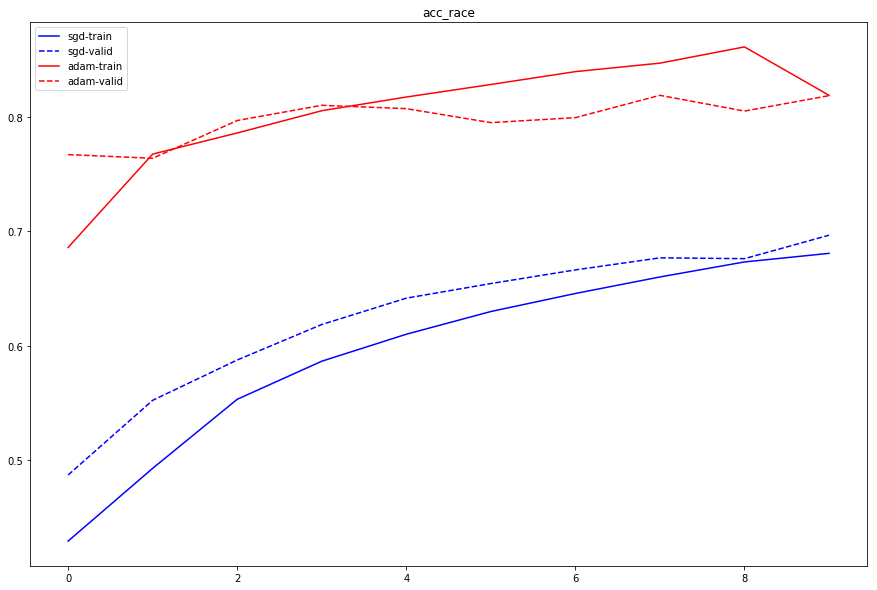

In [57]:
for n in results:
    print(n)
    
    plt.figure(figsize=(15,10))
    plt.title('loss')
    plt.plot(results[n]['sgd']['loss'], 'b', label='sgd-train')
    plt.plot(results[n]['sgd']['val_loss'], 'b--', label='sgd-valid')
    plt.plot(results[n]['adam']['loss'], 'r', label='adam-train')
    plt.plot(results[n]['adam']['val_loss'], 'r--', label='adam-valid')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15,10))
    plt.title('acc_age')
    plt.plot(results[n]['sgd']['acc_age'], 'b', label='sgd-train')
    plt.plot(results[n]['sgd']['val_acc_age'], 'b--', label='sgd-valid')
    plt.plot(results[n]['adam']['acc_age'], 'r', label='adam-train')
    plt.plot(results[n]['adam']['val_acc_age'], 'r--', label='adam-valid')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15,10))
    plt.title('acc_gender')
    plt.plot(results[n]['sgd']['acc_age'], 'b', label='sgd-train')
    plt.plot(results[n]['sgd']['val_acc_age'], 'b--', label='sgd-valid')
    plt.plot(results[n]['adam']['acc_age'], 'r', label='adam-train')
    plt.plot(results[n]['adam']['val_acc_age'], 'r--', label='adam-valid')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15,10))
    plt.title('acc_race')
    plt.plot(results[n]['sgd']['acc_race'], 'b', label='sgd-train')
    plt.plot(results[n]['sgd']['val_acc_race'], 'b--', label='sgd-valid')
    plt.plot(results[n]['adam']['acc_race'], 'r', label='adam-train')
    plt.plot(results[n]['adam']['val_acc_race'], 'r--', label='adam-valid')
    plt.legend()
    plt.show()

# Acc comparision

## SGD

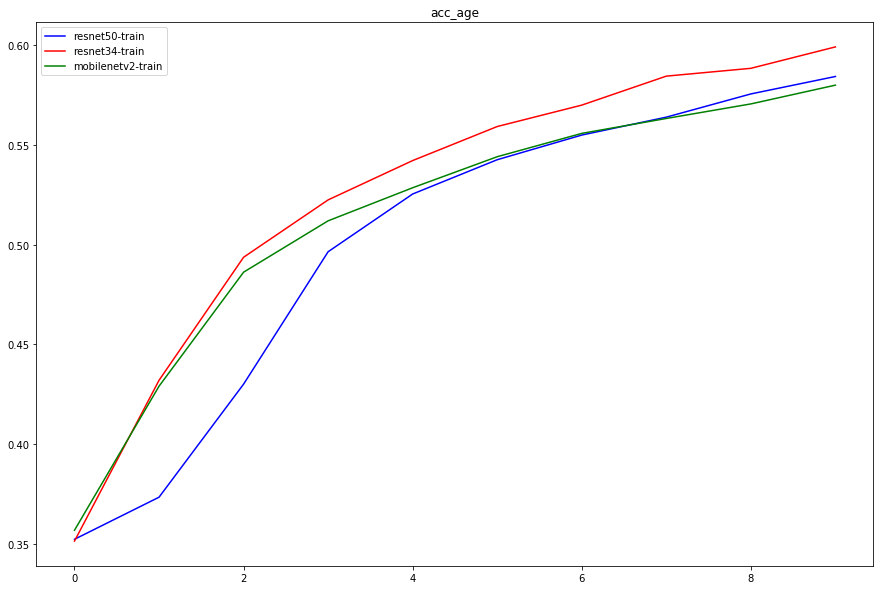

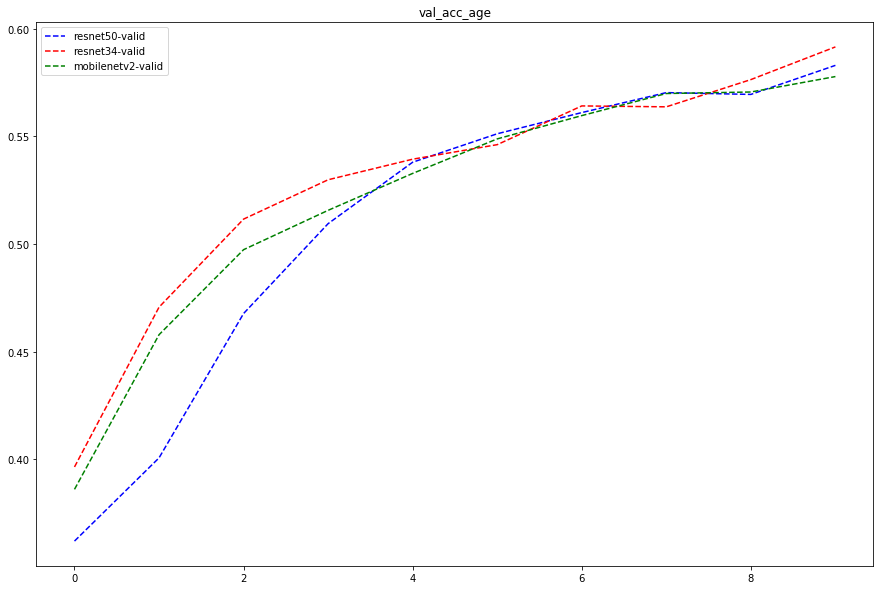

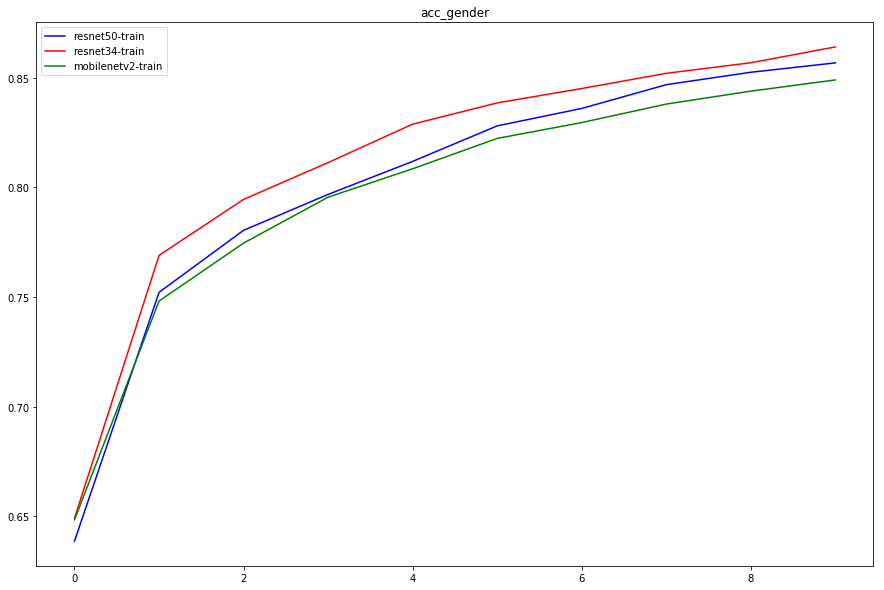

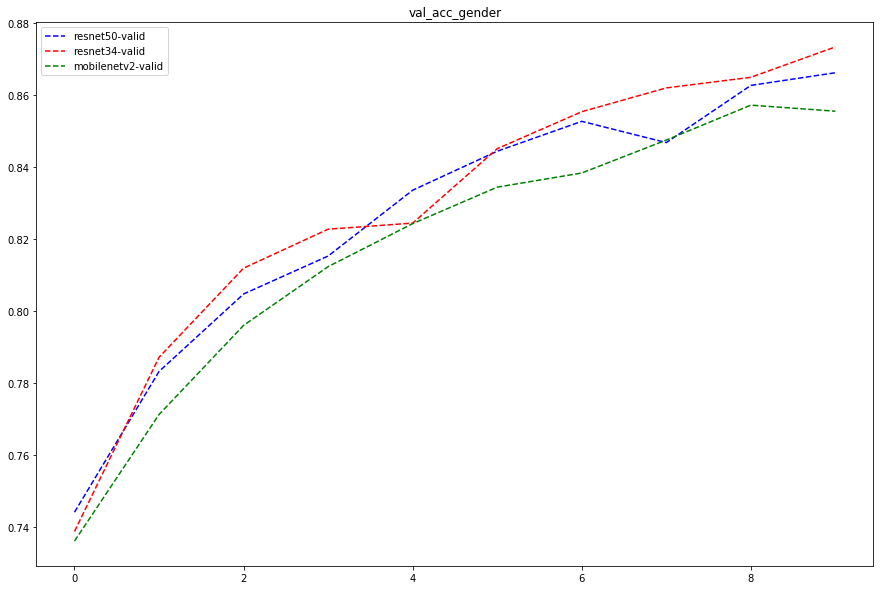

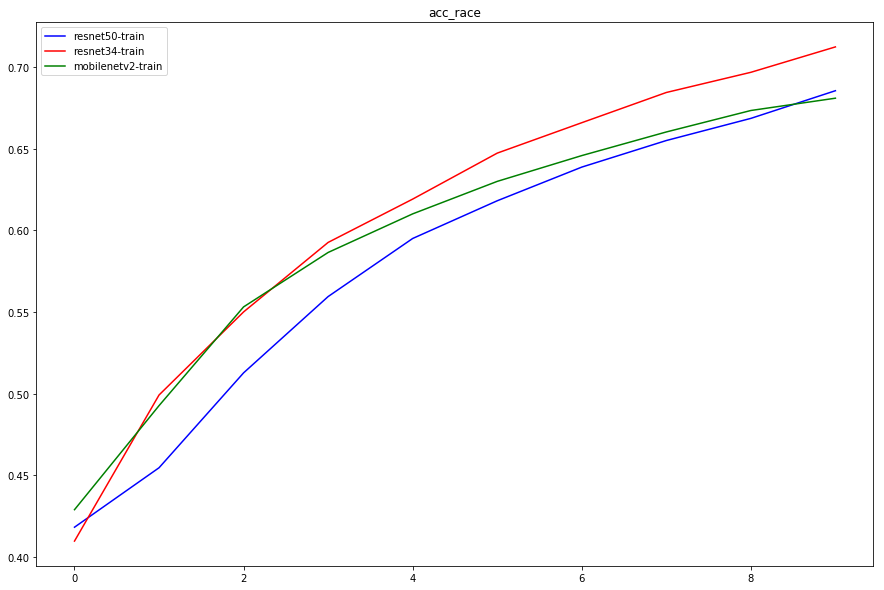

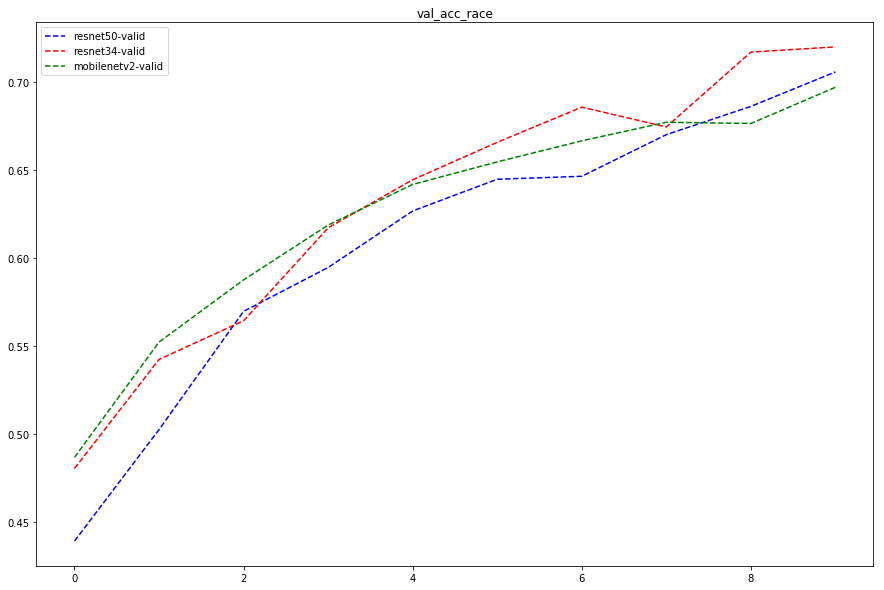

In [58]:
plt.figure(figsize=(15,10))
plt.title('acc_age')
plt.plot(results['resnet50']['sgd']['acc_age'], 'b', label='resnet50-train')
plt.plot(results['resnet34']['sgd']['acc_age'], 'r', label='resnet34-train')
plt.plot(results['mobilenetv2']['sgd']['acc_age'], 'g', label='mobilenetv2-train')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.title('val_acc_age')
plt.plot(results['resnet50']['sgd']['val_acc_age'], 'b--', label='resnet50-valid')
plt.plot(results['resnet34']['sgd']['val_acc_age'], 'r--', label='resnet34-valid')
plt.plot(results['mobilenetv2']['sgd']['val_acc_age'], 'g--', label='mobilenetv2-valid')
plt.legend()
plt.show()
   
plt.figure(figsize=(15,10))
plt.title('acc_gender')
plt.plot(results['resnet50']['sgd']['acc_gender'], 'b', label='resnet50-train')
plt.plot(results['resnet34']['sgd']['acc_gender'], 'r', label='resnet34-train')
plt.plot(results['mobilenetv2']['sgd']['acc_gender'], 'g', label='mobilenetv2-train')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.title('val_acc_gender')
plt.plot(results['resnet50']['sgd']['val_acc_gender'], 'b--', label='resnet50-valid')
plt.plot(results['resnet34']['sgd']['val_acc_gender'], 'r--', label='resnet34-valid')
plt.plot(results['mobilenetv2']['sgd']['val_acc_gender'], 'g--', label='mobilenetv2-valid')
plt.legend()
plt.show()
   
plt.figure(figsize=(15,10))
plt.title('acc_race')
plt.plot(results['resnet50']['sgd']['acc_race'], 'b', label='resnet50-train')
plt.plot(results['resnet34']['sgd']['acc_race'], 'r', label='resnet34-train')
plt.plot(results['mobilenetv2']['sgd']['acc_race'], 'g', label='mobilenetv2-train')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.title('val_acc_race')
plt.plot(results['resnet50']['sgd']['val_acc_race'], 'b--', label='resnet50-valid')
plt.plot(results['resnet34']['sgd']['val_acc_race'], 'r--', label='resnet34-valid')
plt.plot(results['mobilenetv2']['sgd']['val_acc_race'], 'g--', label='mobilenetv2-valid')
plt.legend()
plt.show()

## Adam

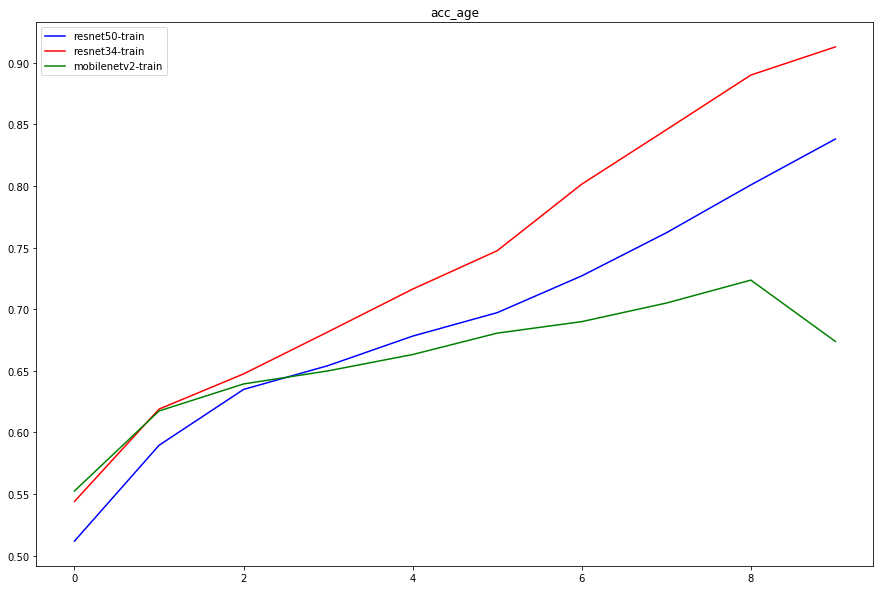

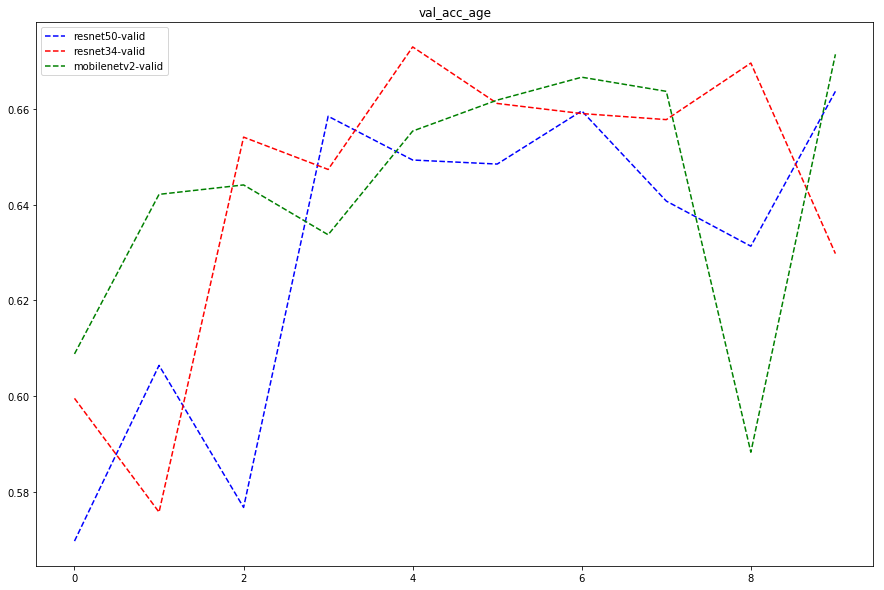

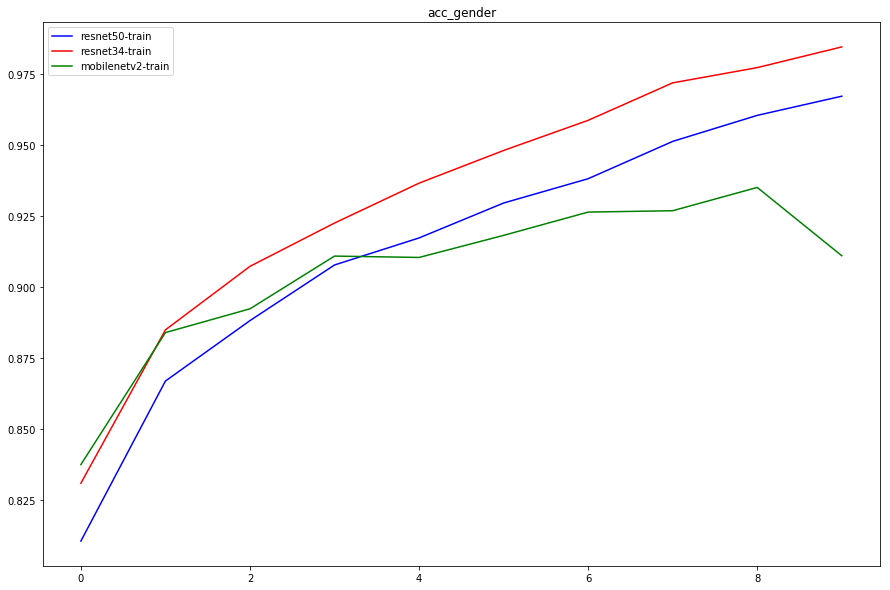

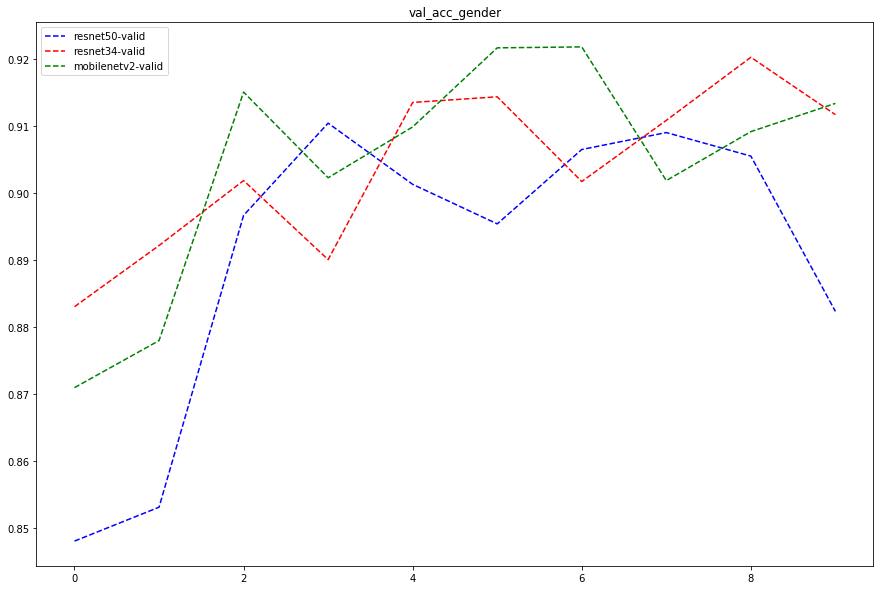

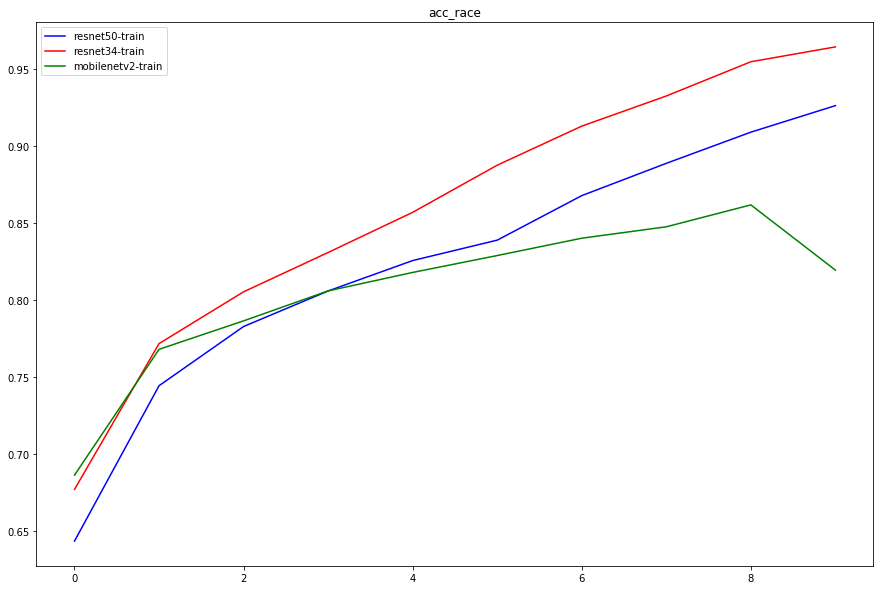

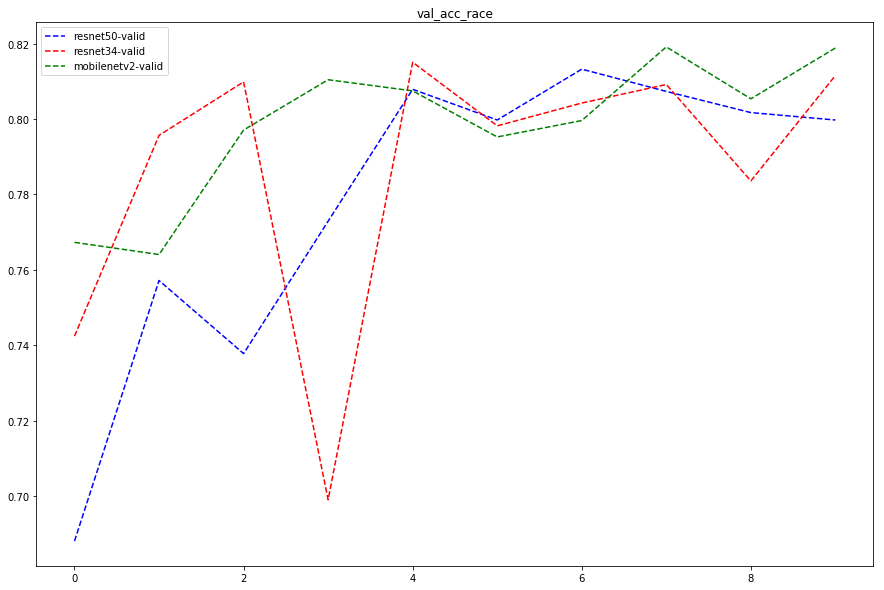

In [59]:
plt.figure(figsize=(15,10))
plt.title('acc_age')
plt.plot(results['resnet50']['adam']['acc_age'], 'b', label='resnet50-train')
plt.plot(results['resnet34']['adam']['acc_age'], 'r', label='resnet34-train')
plt.plot(results['mobilenetv2']['adam']['acc_age'], 'g', label='mobilenetv2-train')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.title('val_acc_age')
plt.plot(results['resnet50']['adam']['val_acc_age'], 'b--', label='resnet50-valid')
plt.plot(results['resnet34']['adam']['val_acc_age'], 'r--', label='resnet34-valid')
plt.plot(results['mobilenetv2']['adam']['val_acc_age'], 'g--', label='mobilenetv2-valid')
plt.legend()
plt.show()
   
plt.figure(figsize=(15,10))
plt.title('acc_gender')
plt.plot(results['resnet50']['adam']['acc_gender'], 'b', label='resnet50-train')
plt.plot(results['resnet34']['adam']['acc_gender'], 'r', label='resnet34-train')
plt.plot(results['mobilenetv2']['adam']['acc_gender'], 'g', label='mobilenetv2-train')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.title('val_acc_gender')
plt.plot(results['resnet50']['adam']['val_acc_gender'], 'b--', label='resnet50-valid')
plt.plot(results['resnet34']['adam']['val_acc_gender'], 'r--', label='resnet34-valid')
plt.plot(results['mobilenetv2']['adam']['val_acc_gender'], 'g--', label='mobilenetv2-valid')
plt.legend()
plt.show()
   
plt.figure(figsize=(15,10))
plt.title('acc_race')
plt.plot(results['resnet50']['adam']['acc_race'], 'b', label='resnet50-train')
plt.plot(results['resnet34']['adam']['acc_race'], 'r', label='resnet34-train')
plt.plot(results['mobilenetv2']['adam']['acc_race'], 'g', label='mobilenetv2-train')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.title('val_acc_race')
plt.plot(results['resnet50']['adam']['val_acc_race'], 'b--', label='resnet50-valid')
plt.plot(results['resnet34']['adam']['val_acc_race'], 'r--', label='resnet34-valid')
plt.plot(results['mobilenetv2']['adam']['val_acc_race'], 'g--', label='mobilenetv2-valid')
plt.legend()
plt.show()

# ResNet50 50 epochs

In [61]:
results50=json.load(open('utkface_res2.json','r'))

resnet50 sgd
		loss	val_loss	acc_age	val_acc_age	acc_gender	val_acc_gender	acc_race	val_acc_race
Epoch 01	3.557	3.264		0.357	0.406		0.682		0.774		0.430		0.494
Epoch 02	3.110	2.842		0.450	0.519		0.772		0.812		0.515		0.587
Epoch 03	2.803	2.599		0.520	0.537		0.796		0.832		0.577		0.611
Epoch 04	2.591	2.374		0.539	0.561		0.820		0.855		0.622		0.655
Epoch 05	2.443	2.218		0.550	0.580		0.830		0.861		0.648		0.691
Epoch 06	2.328	2.101		0.567	0.591		0.840		0.870		0.673		0.711
Epoch 07	2.241	2.017		0.575	0.598		0.850		0.879		0.688		0.729
Epoch 08	2.153	2.000		0.587	0.588		0.857		0.874		0.703		0.741
Epoch 09	2.075	1.921		0.599	0.611		0.865		0.878		0.719		0.749
Epoch 10	2.018	1.839		0.602	0.615		0.866		0.892		0.730		0.764
Epoch 11	1.960	1.810		0.617	0.622		0.875		0.891		0.738		0.761
Epoch 12	1.917	1.774		0.618	0.625		0.875		0.891		0.745		0.777
Epoch 13	1.875	1.738		0.629	0.635		0.883		0.898		0.756		0.774
Epoch 14	1.833	1.696		0.635	0.640		0.882		0.905		0.765		0.783
Epoch 15	1.791	1.693		0.637	0.636		

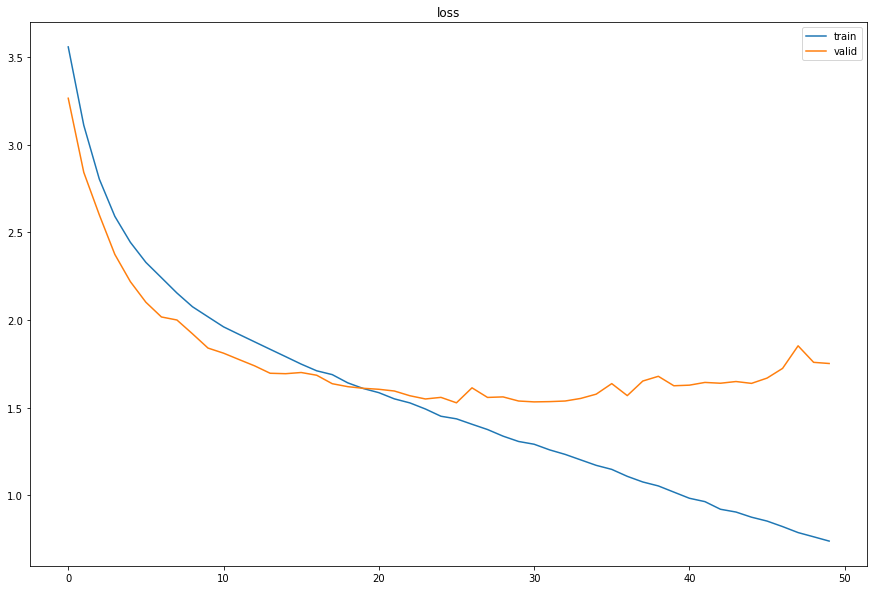

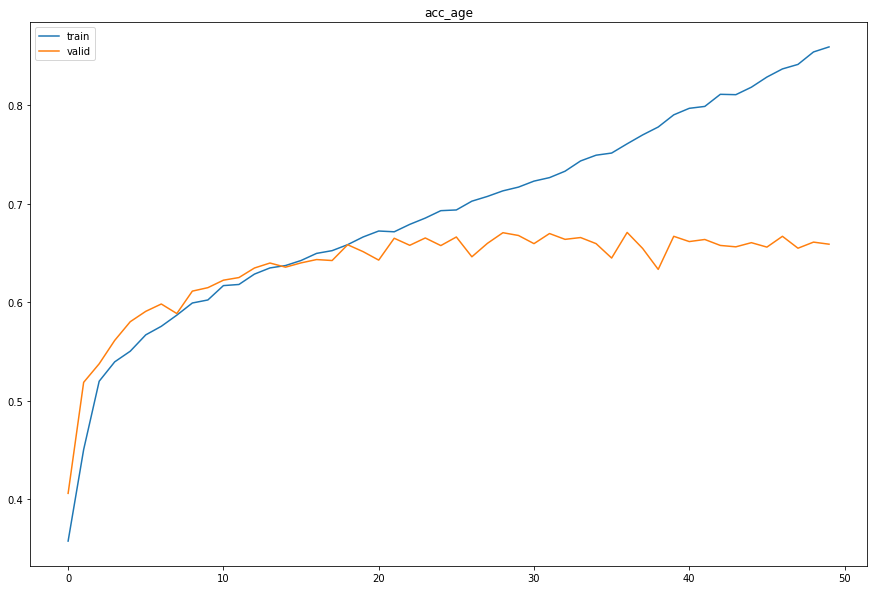

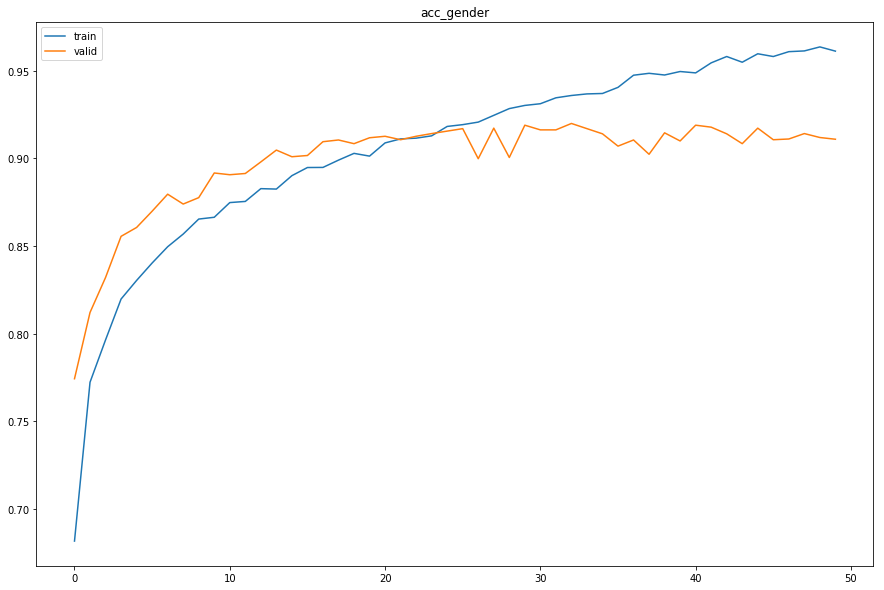

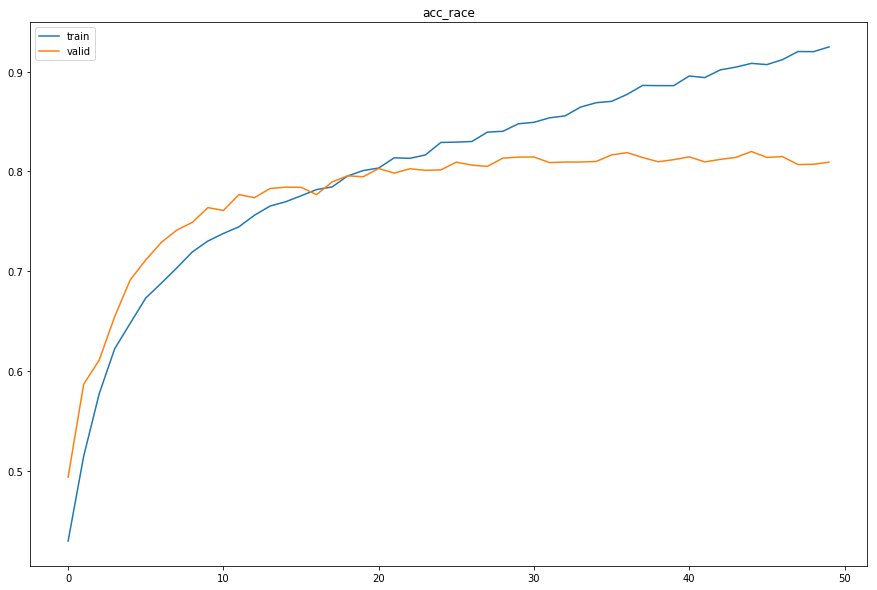

resnet50 adam
		loss	val_loss	acc_age	val_acc_age	acc_gender	val_acc_gender	acc_race	val_acc_race
Epoch 01	3.274	4.840		0.425	0.165		0.677		0.738		0.495		0.512
Epoch 02	2.516	2.510		0.520	0.499		0.810		0.843		0.633		0.613
Epoch 03	2.166	2.219		0.566	0.538		0.850		0.861		0.704		0.701
Epoch 04	1.950	1.941		0.594	0.596		0.871		0.878		0.738		0.755
Epoch 05	1.776	1.932		0.622	0.596		0.891		0.886		0.769		0.765
Epoch 06	1.647	1.914		0.641	0.579		0.900		0.890		0.792		0.770
Epoch 07	1.515	1.827		0.661	0.617		0.911		0.892		0.811		0.766
Epoch 08	1.388	1.778		0.685	0.631		0.924		0.893		0.833		0.774
Epoch 09	1.270	1.719		0.708	0.651		0.933		0.891		0.850		0.790
Epoch 10	1.131	1.824		0.733	0.632		0.942		0.892		0.869		0.793
Epoch 11	0.995	1.775		0.760	0.650		0.952		0.897		0.887		0.798
Epoch 12	0.873	1.985		0.787	0.644		0.959		0.895		0.906		0.785
Epoch 13	0.755	2.092		0.824	0.641		0.967		0.873		0.919		0.782
Epoch 14	0.640	2.164		0.845	0.638		0.969		0.888		0.935		0.775
Epoch 15	0.554	2.495		0.868	0.599	

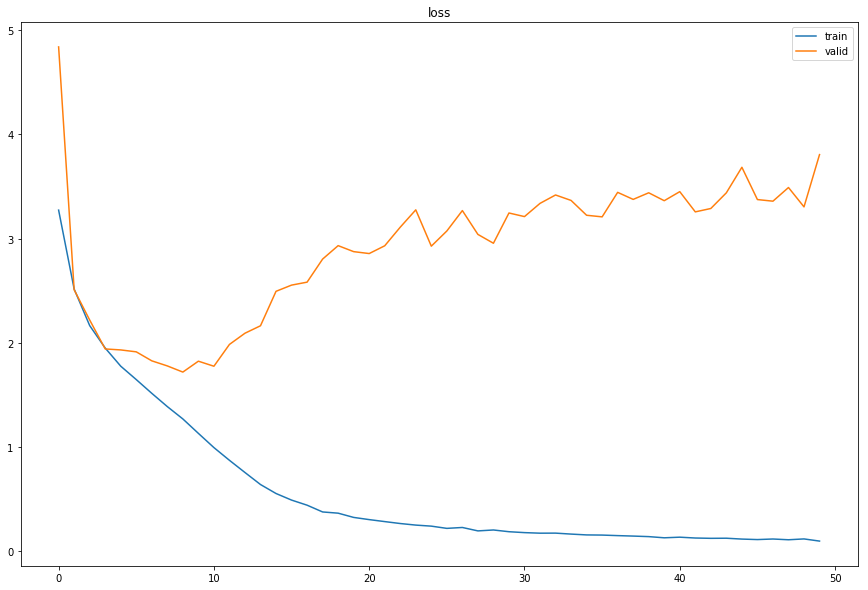

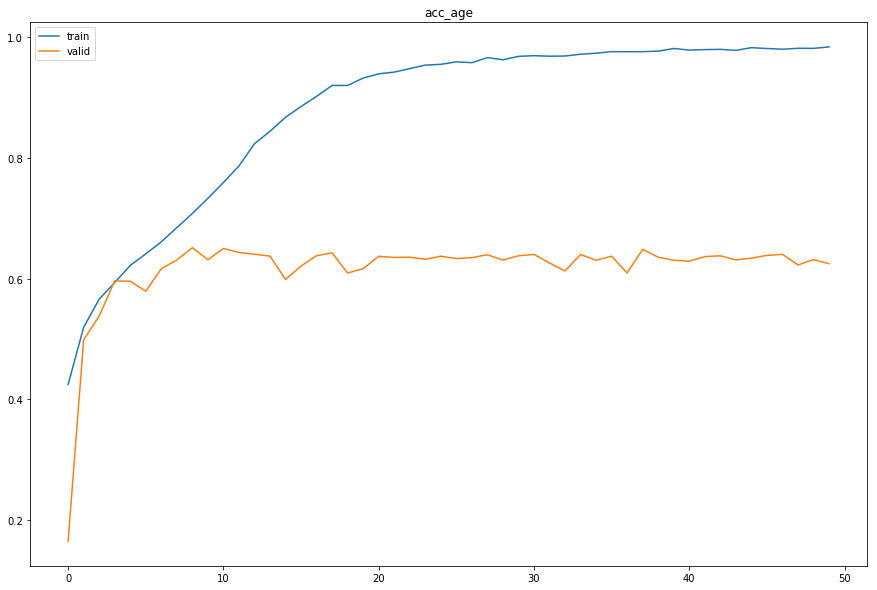

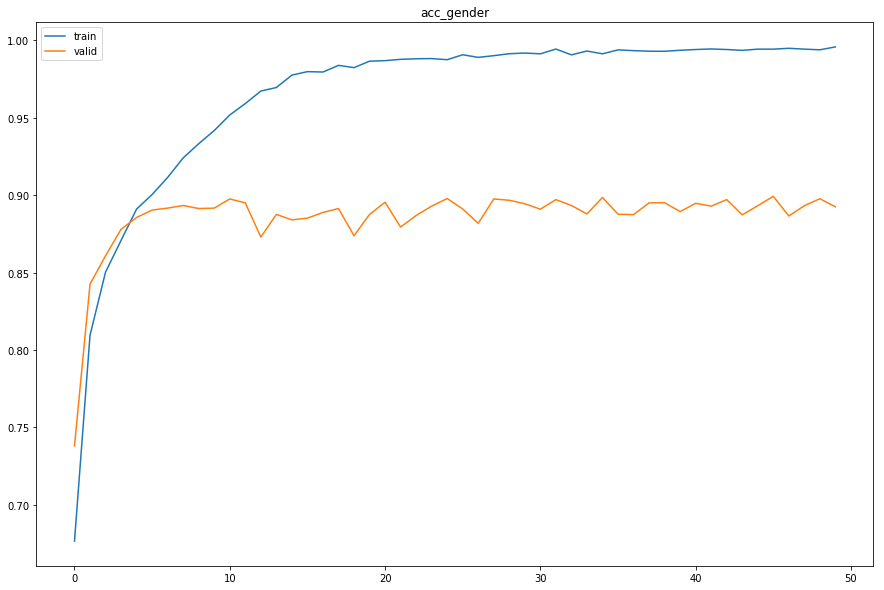

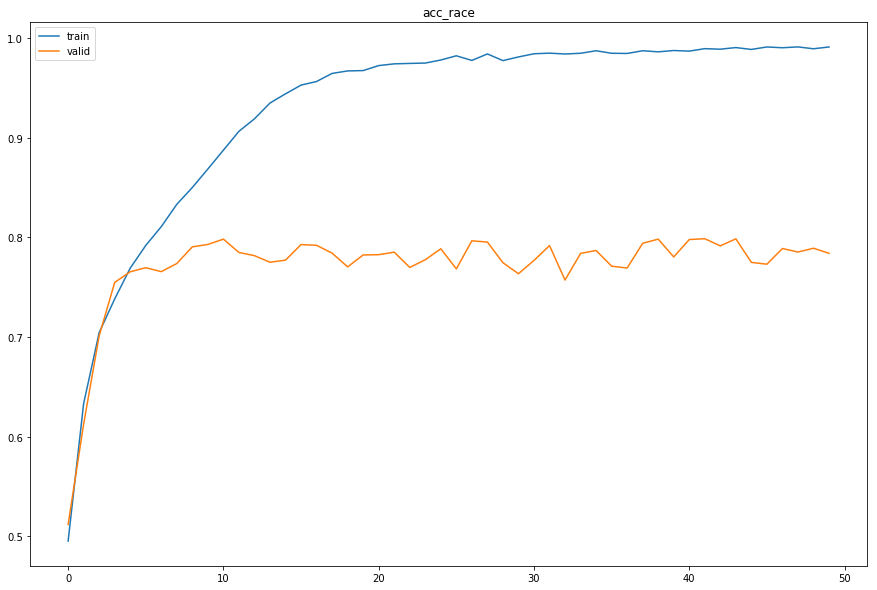

In [71]:
for n in results50:
    for o in results50[n]:
        print(n, o)
        print(f"""\t\tloss\tval_loss\tacc_age\tval_acc_age\tacc_gender\tval_acc_gender\tacc_race\tval_acc_race""")
        for e in range(50):
            print(f"""Epoch {str(e + 1).zfill(2)}\t{results50[n][o]['loss'][e]:.3f}\t{results50[n][o]['val_loss'][e]:.3f}\t\t{results50[n][o]['acc_age'][e]:.3f}\t{results50[n][o]['val_acc_age'][e]:.3f}\t\t{results50[n][o]['acc_gender'][e]:.3f}\t\t{results50[n][o]['val_acc_gender'][e]:.3f}\t\t{results50[n][o]['acc_race'][e]:.3f}\t\t{results50[n][o]['val_acc_race'][e]:.3f}""")
        plt.figure(figsize=(15,10))
        plt.title('loss')
        plt.plot(results50[n][o]['loss'], label='train')
        plt.plot(results50[n][o]['val_loss'], label='valid')
        plt.legend()
        plt.show()

        plt.figure(figsize=(15,10))
        plt.title('acc_age')
        plt.plot(results50[n][o]['acc_age'], label='train')
        plt.plot(results50[n][o]['val_acc_age'], label='valid')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(15,10))
        plt.title('acc_gender')
        plt.plot(results50[n][o]['acc_gender'], label='train')
        plt.plot(results50[n][o]['val_acc_gender'], label='valid')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(15,10))
        plt.title('acc_race')
        plt.plot(results50[n][o]['acc_race'], label='train')
        plt.plot(results50[n][o]['val_acc_race'], label='valid')
        plt.legend()
        plt.show()

resnet50


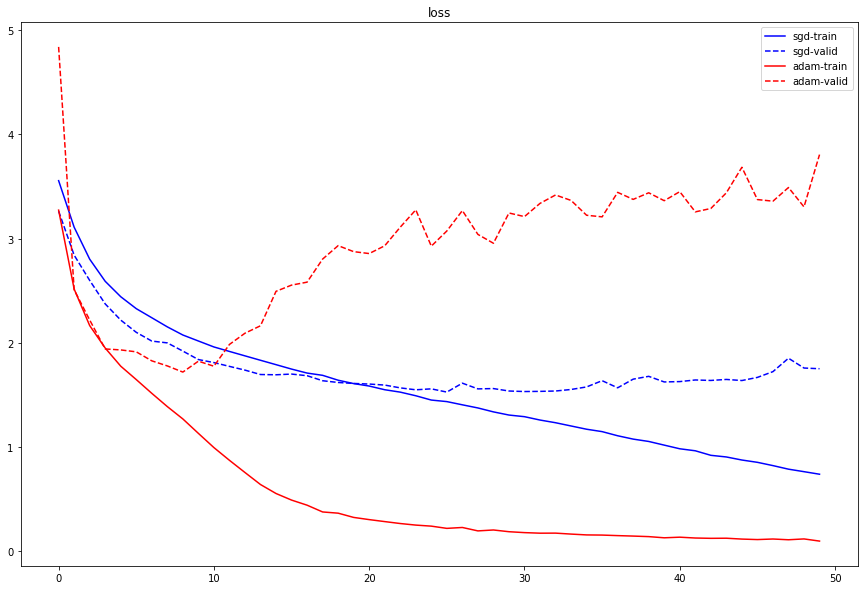

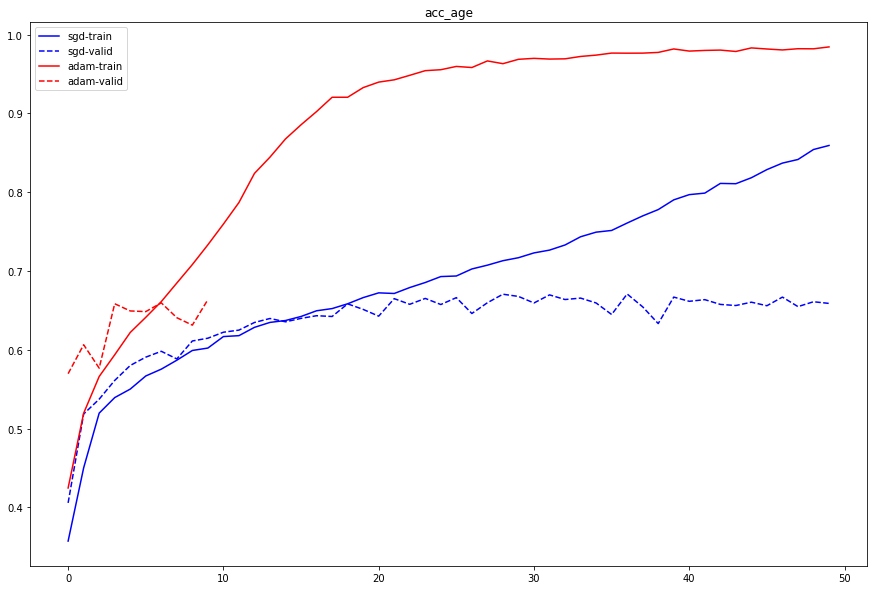

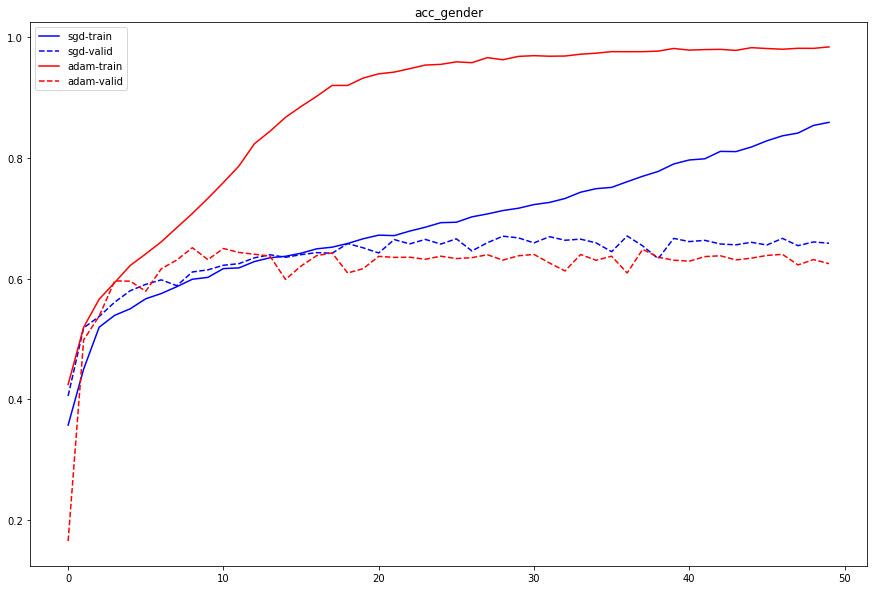

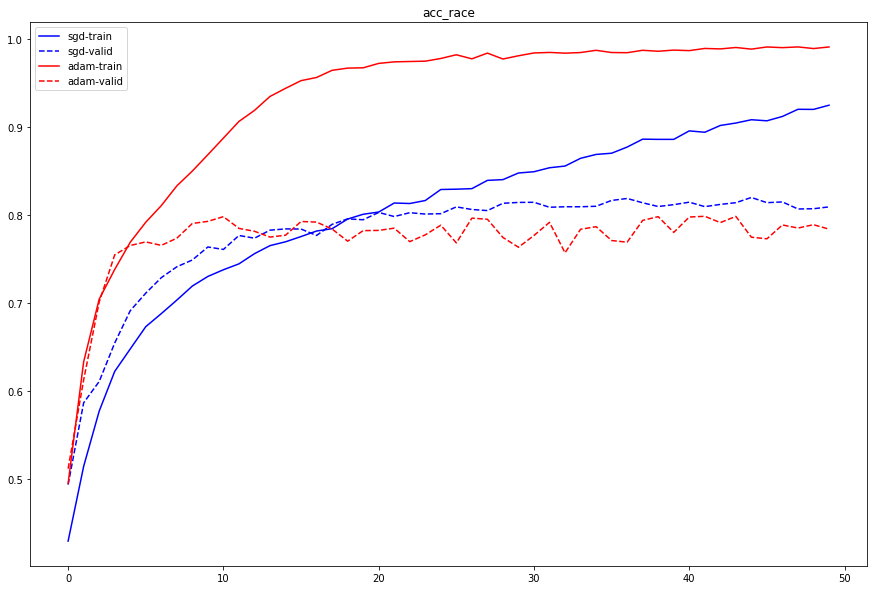

In [73]:
for n in results50:
    print(n)
    
    plt.figure(figsize=(15,10))
    plt.title('loss')
    plt.plot(results50[n]['sgd']['loss'], 'b', label='sgd-train')
    plt.plot(results50[n]['sgd']['val_loss'], 'b--', label='sgd-valid')
    plt.plot(results50[n]['adam']['loss'], 'r', label='adam-train')
    plt.plot(results50[n]['adam']['val_loss'], 'r--', label='adam-valid')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15,10))
    plt.title('acc_age')
    plt.plot(results50[n]['sgd']['acc_age'], 'b', label='sgd-train')
    plt.plot(results50[n]['sgd']['val_acc_age'], 'b--', label='sgd-valid')
    plt.plot(results50[n]['adam']['acc_age'], 'r', label='adam-train')
    plt.plot(results[n]['adam']['val_acc_age'], 'r--', label='adam-valid')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15,10))
    plt.title('acc_gender')
    plt.plot(results50[n]['sgd']['acc_age'], 'b', label='sgd-train')
    plt.plot(results50[n]['sgd']['val_acc_age'], 'b--', label='sgd-valid')
    plt.plot(results50[n]['adam']['acc_age'], 'r', label='adam-train')
    plt.plot(results50[n]['adam']['val_acc_age'], 'r--', label='adam-valid')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15,10))
    plt.title('acc_race')
    plt.plot(results50[n]['sgd']['acc_race'], 'b', label='sgd-train')
    plt.plot(results50[n]['sgd']['val_acc_race'], 'b--', label='sgd-valid')
    plt.plot(results50[n]['adam']['acc_race'], 'r', label='adam-train')
    plt.plot(results50[n]['adam']['val_acc_race'], 'r--', label='adam-valid')
    plt.legend()
    plt.show()